# Final competition of Deep Learning 2020 Spring
Traffic environment semi-supervised Learning Contest

## Goals
The objective is to train a model using images captured by six different cameras attached to the same car to generate a top down view of the surrounding area. The performance of the model will be evaluated by (1) the ability of detecting objects (like car, trucks, bicycles, etc.) and (2) the ability to draw the road map layout.

## Data
You will be given two sets of data:

 1. Unlabeled set: just images
 2. Labeled set: images and the labels(bounding box and road map layout)

This notebook will help you understand the dataset.

In [1]:
!nvidia-smi

Fri May  1 15:37:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:05:00.0 Off |                  N/A |
| 28%   35C    P2    32W / 180W |      0MiB /  8119MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import time
import sys
import random
import psutil

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from sklearn.metrics import confusion_matrix

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../../DLSP20Dataset/data'
annotation_csv = '../../DLSP20Dataset/data/annotation.csv'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.is_available()

In [8]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def order_points(pts):
    from scipy.spatial import distance as dist
    import numpy as np
    
    xSorted = pts[np.argsort(pts[:, 0]), :]

    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    return np.array([tl, tr, br, bl], dtype="float32")

def arrange_box(x1,y1):
    box=np.array(list(zip(x1,y1)))
    box=order_points(box)
    return box

def iou(box1, box2):
    from shapely.geometry import Polygon
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area

#def iou(xy1,xy2):
#    
#    from shapely.geometry import Polygon
#    
#    boxA = Polygon(arrange_box(xy1[0],xy1[1])).buffer(1e-9)
#    boxB = Polygon(arrange_box(xy2[0],xy2[1])).buffer(1e-9)
#    
#    try:
#        return boxA.intersection(boxB).area / boxA.union(boxB).area
#    except:
#        print('Box 1:',xy1[0],xy1[1])
#        print('Box 2:',xy2[0],xy2[1])
#        sys.exit(1)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def calculate_overlap(target_bb, predicted_bb):
    overlaps = torch.zeros(target_bb.size(0),predicted_bb.size(0))

    for j in range(overlaps.shape[0]):
        for k in range(overlaps.shape[1]):
            overlaps[j][k] = iou(target_bb[j],predicted_bb[k])
            
    return overlaps

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

from skimage import draw
import numpy as np

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = torch.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

def convert_to_binary_mask(corners, shape=(800,800)):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    x,y = point_squence.T[0].detach() * 10 + 400, -point_squence.T[1].detach() * 10 + 400
    new_im = poly2mask(y, x, shape)
    return new_im

def create_conf_matrix(target, pred, debug=True):
    import sys
    
    target = target.reshape(-1)
    pred = pred.reshape(-1)
    
    if debug:
        print('Target values:', target.unique())
        print('Predicted values:', pred.unique())
        print('Target shape:', target.shape)
        print('Predicted shape:', pred.shape)
    
    nb_classes = max(target.unique())
    if len(pred.unique()) > (nb_classes+1) :
        print('More predicted classes than true classes')
        sys.exit(1)
        
    conf_matrix = torch.zeros(nb_classes+1, nb_classes+1)
    for t, p in zip(target, pred):
        conf_matrix[t, p] += 1
    
    return conf_matrix

def create_conf_matrix2(target, pred, debug=True):
    import sys
    
    target = target.reshape(-1).cpu().numpy()
    pred = pred.reshape(-1).cpu().numpy()
    
        
    conf_matrix = torch.from_numpy(confusion_matrix(target, pred)).to(device)
    
    print('Threat Score: {}'.format((1.0*conf_matrix[1,1])/(conf_matrix[1,1]+conf_matrix[1,0]+conf_matrix[0,1])))
    
    return conf_matrix

def classScores(conf_matrix):
    print('Confusion matrix\n', conf_matrix)
    TP = conf_matrix.diag()
    TN = torch.zeros_like(TP)
    FP = torch.zeros_like(TP)
    FN = torch.zeros_like(TP)
    for c in range(conf_matrix.size(0)):
        idx = torch.ones(conf_matrix.size(0)).byte()
        idx[c] = 0
        # all non-class samples classified as non-class
        TN[c] = conf_matrix[idx.nonzero()[:, None], idx.nonzero()].sum() #conf_matrix[idx[:, None], idx].sum() - conf_matrix[idx, c].sum()
        # all non-class samples classified as class
        FP[c] = conf_matrix[idx, c].sum()
        # all class samples not classified as class
        FN[c] = conf_matrix[c, idx].sum()

        print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(
            c, TP[c], TN[c], FP[c], FN[c]))
        
    return TP, TN, FP, FN

def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

# Dataset

You will get two different datasets:

 1. an unlabeled dataset for pre-training
 2. a labeled dataset for both training and validation
 
## The dataset is organized into three levels: scene, sample and image

 1. A scene is 25 seconds of a car's journey.
 2. A sample is a snapshot of a scene at a given timeframe. Each scene will be divided into 126 samples, so about 0.2 seconds between consecutive samples.
 3. Each sample contains 6 images captured by camera facing different orientation.
    Each camera will capture 70 degree view. To make it simple, you can safely assume that the angle between the cameras is 60 degrees 

106 scenes in the unlabeled dataset and 28 scenes in the labeled dataset

In [14]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

train_scene_index = np.random.choice(labeled_scene_index, int(np.ceil(0.8*len(labeled_scene_index))))

test_scene_index = labeled_scene_index[np.isin(labeled_scene_index, train_scene_index,invert=True)]

# Unlabeled dataset

You get two ways to access the dataset, by sample or by image

## Get Sample

In [17]:
#transform = torchvision.transforms.ToTensor()

transform=torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                          torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=16, shuffle=True, num_workers=2)

In [18]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([16, 6, 3, 256, 256])


In [19]:
sample[0][1].shape

torch.Size([3, 256, 256])

In [20]:
torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0).shape

(518, 776, 3)

## Get individual image

In [21]:
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=2, shuffle=True, num_workers=2)

In [22]:
# [batch_size, 3, H, W]
image, camera_index = iter(trainloader).next()
print(image.shape)

torch.Size([2, 3, 256, 256])


In [23]:
# Camera_index is to tell you which camera is used. The order is
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
print(camera_index[0])

tensor(2)


# Labeled dataset

In [24]:
batch_size = 8

In [25]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

trainloader = torch.utils.data.DataLoader(labeled_trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=2, 
                                          collate_fn=collate_fn)

labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

testloader = torch.utils.data.DataLoader(labeled_testset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=2, 
                                          collate_fn=collate_fn)

In [26]:
sample, target, road_image, extra = iter(trainloader).next()

There are two kind of labels

 1. The bounding box of surrounding objects
 2. The binary road_image

In [27]:
len(sample)

8

In [28]:
n_feature = 20

In [29]:
torch.stack(road_image).shape

torch.Size([8, 800, 800])

In [30]:
class ConvLayer(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 bias = True, 
                 pool=False,
                 mp_kernel_size=2, 
                 mp_stride=2):
        super(ConvLayer, self).__init__()
        if pool:
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU(), 
                nn.MaxPool2d(kernel_size=mp_kernel_size, stride=mp_stride))
        else:
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU(), 
                )
        
    def forward(self, x):
        return self.layer(x)

class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearLayer, self).__init__()
        self.layer = nn.Sequential(
            torch.nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(0.5),
            nn.LeakyReLU(negative_slope=0.1) ## nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer(x)

class ConvTLayer(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 output_padding=0, 
                 unpool=False,
                 mp_kernel_size=2, 
                 mp_stride=2):
        super(ConvTLayer, self).__init__()
        if unpool:
            self.layer = nn.Sequential(
                nn.ConvTranspose2d(in_channels, 
                                   out_channels, 
                                   kernel_size, 
                                   stride=stride, 
                                   padding=padding, 
                                   output_padding=output_padding, 
                                   bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU()
                nn.MaxUnpool2d(kernel_size=mp_kernel_size, stride=mp_stride)
            )
        else:
            self.layer = nn.Sequential(
                nn.ConvTranspose2d(in_channels, 
                                   out_channels, 
                                   kernel_size, 
                                   stride=stride, 
                                   padding=padding, 
                                   output_padding=output_padding, 
                                   bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.LeakyReLU(negative_slope=0.1), ## nn.ReLU()
            )        
    def forward(self, x):
        return self.layer(x)

class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()
        self.conv1 = ConvLayer(3,96, stride=2)
        self.conv2 = ConvLayer(96,128, stride=2)
        self.conv3 = ConvLayer(128,256, stride=2)
        self.conv4 = ConvLayer(256,512, stride=2)
        self.conv5 = ConvLayer(512,1024, padding=(0,0))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x
    
class EncoderY(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()
        self.conv1 = ConvLayer(3,96, stride=2)
        self.conv2 = ConvLayer(96,128, stride=2)
        self.conv3 = ConvLayer(128,256, stride=2)
        self.conv4 = ConvLayer(256,512, stride=2)
        self.conv5 = ConvLayer(512,1024, padding=(0,0))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder = Encoder()
        self.linear = nn.Linear(1024*7*7,1)
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.linear(x.reshape(-1,1024*7*7))
        return torch.sigmoid(x)

class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.encoder = Encoder1()
        self.linear = nn.Linear(1024*13*13,1)
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.linear(x.reshape(-1,1024*13*13))
        return torch.sigmoid(x)

def random_vector(batch_size, length):
    # Sample from a Gaussian distribution
    z_vec = torch.randn(batch_size, length, 1, 1).float()
    if torch.cuda.is_available():
        z_vec = z_vec.to(device)
    return z_vec

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convt1 = ConvTLayer(4096, 2048, stride=2)
        self.convt2 = ConvTLayer(2048, 1024, stride=2, output_padding=(0,0))
        self.convt3 = ConvTLayer(1024, 512, stride=2, padding=(1,1), output_padding=(1,1))
        self.convt4 = ConvTLayer(512, 256, stride=2, output_padding=(1,1))
        self.convt5 = ConvTLayer(256, 128, stride=2, output_padding=(1,1))
        self.convt6 = ConvTLayer(128, 96, stride=2, output_padding=(1,1))
        self.convt7 = ConvTLayer(96, 64, stride=2, output_padding=(1,1))
        self.convt8 = ConvTLayer(64, 32, stride=1, output_padding=(0,0))
        self.convt9 = ConvTLayer(32, 18, stride=1, padding=(1,1), output_padding=(0,0))
        
    def forward(self,z):
        z = self.convt1(z)
        z = self.convt2(z)
        z = self.convt3(z)
        z = self.convt4(z)
        z = self.convt5(z)
        z = self.convt6(z)
        z = self.convt7(z)
        z = self.convt8(z)
        z = self.convt9(z)
        return z

class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()
        self.convt1 = ConvTLayer(4096, 2048, stride=2)
        self.convt2 = ConvTLayer(2048, 1024, stride=2, output_padding=(1,1))
        self.convt3 = ConvTLayer(1024, 512, stride=2, padding=(1,1), output_padding=(0,0))
        self.convt4 = ConvTLayer(512, 256, stride=2, output_padding=(0,0))
        self.convt5 = ConvTLayer(256, 128, stride=2, output_padding=(0,0))
        self.convt6 = ConvTLayer(128, 96, stride=2, output_padding=(0,0))
        self.convt7 = ConvTLayer(96, 3, stride=2, output_padding=(1,1))
        
    def forward(self,z):
        z = self.convt1(z)
        z = self.convt2(z)
        z = self.convt3(z)
        z = self.convt4(z)
        z = self.convt5(z)
        z = self.convt6(z)
        z = self.convt7(z)
        return z

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.decoder = Decoder()
        
    def forward(self,x):
        x = self.decoder(x)
        return torch.tanh(x).reshape(6,-1,3,256,256)

class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        self.decoder = Decoder1()
        
    def forward(self,x):
        x = self.decoder(x)
        return torch.tanh(x)

In [31]:
!nvidia-smi

Fri May  1 15:37:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:05:00.0 Off |                  N/A |
| 28%   31C    P8     6W / 180W |     10MiB /  8119MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [32]:
class EncoderY(nn.Module):
    def __init__(self,  d):
        super(EncoderY, self).__init__()
        self.conv1 = ConvLayer(3,96, stride=2)
        self.conv2 = ConvLayer(96,128, stride=2)
        self.conv3 = ConvLayer(128,256, stride=2)
        self.conv4 = ConvLayer(256,512, stride=2)
        self.conv5 = ConvLayer(512,1024, stride=2)
        self.conv6 = ConvLayer(1024,2048, stride=2)
        self.lin1 = nn.Linear(2048*3*3, d)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = self.lin1(x.reshape(-1,2048*3*3))
        return x

In [33]:
class EncoderX(nn.Module):
    def __init__(self, d):
        super(EncoderX, self).__init__()
        self.conv1 = ConvLayer(1,16, stride=2)
        self.conv2 = ConvLayer(16,32, stride=2)
        self.conv3 = ConvLayer(32,48, stride=2)
        self.conv4 = ConvLayer(48,64, stride=2)
        self.conv5 = ConvLayer(64,96, stride=2)
        self.conv6 = ConvLayer(96,128, stride=2)
        self.conv7 = ConvLayer(128,256, stride=2)
        self.conv8 = ConvLayer(256,512, stride=2)
        self.lin1 = nn.Linear(512*2*2, d)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        #print(x.shape)
        x = self.lin1(x.reshape(-1,512*2*2))
        return x

In [34]:
class DecoderX(nn.Module):
    def __init__(self):
        super(DecoderX, self).__init__()
        self.convt1 = ConvTLayer(4096, 2048, kernel_size=3, stride=2)
        self.convt2 = ConvTLayer(2048, 1024, kernel_size=3, stride=3, output_padding=(0,0))
        self.convt3 = ConvTLayer(1024, 512, kernel_size=3, stride=2, padding=(1,1), output_padding=(0,0))
        self.convt4 = ConvTLayer(512, 256, kernel_size=3, stride=3, padding=(1,1), output_padding=(0,0))
        self.convt5 = ConvTLayer(256, 128, kernel_size=3, stride=2, output_padding=(0,0))
        self.convt6 = ConvTLayer(128, 96, kernel_size=3, stride=2, output_padding=(0,0))
        self.convt7 = ConvTLayer(96, 64, kernel_size=3, stride=2, output_padding=(0,0))
        self.convt8 = ConvTLayer(64, 1, kernel_size=3, stride=2, output_padding=(1,1))
        
    def forward(self,z):
        z = self.convt1(z)
        z = self.convt2(z)
        z = self.convt3(z)
        z = self.convt4(z)
        z = self.convt5(z)
        z = self.convt6(z)
        z = self.convt7(z)
        z = self.convt8(z)
        return torch.sigmoid(z)

In [35]:
# Defining the model

class CNN_VAE(nn.Module):
    def __init__(self, hidden_d=286, image_d=625): #hidden_d=196, image_d=650 or hidden_d=286, image_d=625
        super().__init__()
        
        self.d = hidden_d
        self.id = image_d
        
        self.y_encoder = EncoderY(d=self.id)

        self.x_encoder = EncoderX(d=2*self.d)

        self.x_decoder = DecoderX()

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, y):
        mu_logvar = self.x_encoder(x).view(-1, 2, self.d)
        #print(mu_logvar.shape)
        img_enc = [self.y_encoder(img.squeeze()) for img in y] 
        mu = mu_logvar[:, 0, :]
        #print(mu.shape)
        logvar = mu_logvar[:, 1, :]
        #print(logvar.shape)
        z = self.reparameterise(mu, logvar)
        img_enc.append(z)
        out = torch.cat(img_enc,axis=1).reshape(-1,4096,1,1)
        return self.x_decoder(out), mu, logvar
    
    def inference(self, y, mu=None, logvar=None):
        N = y.size(1)
        z = torch.randn((N, self.d)).to(device)
        #print('Prior:',z.shape)
        if mu is not None and logvar is not None:
            #print(mu.shape)
            #print(logvar.shape)
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            z = eps.mul(std).add_(mu)
            #print('Post:',z.shape)
        z = z.reshape(-1,196)
        img_enc = [self.y_encoder(img.squeeze()) for img in y] 
        img_enc.append(z)
        out = torch.cat(img_enc,axis=1).reshape(-1,4096,1,1)
        return self.x_decoder(out)
    

In [36]:
    
model = CNN_VAE().to(device)
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [37]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat.view(-1, 800*800), x.view(-1, 800*800), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

====> Epoch: 0 Average loss: 389881.2021
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.604794442653656
tensor([[2479693,  579691],
        [ 463773, 1596843]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.6047964096069336
tensor([[2479700,  579684],
        [ 463772, 1596844]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.6131190061569214
tensor([[2540266,  519118],
        [ 478932, 1581684]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.6131162643432617
tensor([[2540251,  519133],
        [ 478930, 1581686]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.6193121671676636
tensor([[2586055,  473329],
        [ 491313, 1569303]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.6193090081214905
tensor([[2586042,  473342],
        [ 491313, 1569303]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat Sc

Threat Score: 0.6427858471870422
tensor([[2793933,  265451],
        [ 565453, 1495163]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6427600979804993
tensor([[2794221,  265163],
        [ 565698, 1494918]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.6427599787712097
tensor([[2794219,  265165],
        [ 565697, 1494919]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6427336931228638
tensor([[2794508,  264876],
        [ 565944, 1494672]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.6427322626113892
tensor([[2794503,  264881],
        [ 565944, 1494672]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6427129507064819
tensor([[2794805,  264579],
        [ 566183, 1494433]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.642711877822876
tensor([[2794798,  264586],
        [ 566181, 1494435]], de

Threat Score: 0.7044895887374878
Threat Score: 0.5204041600227356
Threat Score: 0.6068795323371887
Threat Score: 0.6735873222351074
Threat Score: 0.6513770818710327
Threat Score: 0.6834357976913452
Threat Score: 0.7072418928146362
Threat Score: 0.5953986644744873
Threat Score: 0.6765514612197876
Threat Score: 0.5851094722747803
Threat Score: 0.5373954176902771
Threat Score: 0.646762490272522
Threat Score: 0.6763216257095337
Threat Score: 0.624026894569397
Threat Score: 0.6431037187576294
Threat Score: 0.7655560374259949
Threat Score: 0.7627184987068176
Threat Score: 0.5887640118598938
Threat Score: 0.6825690865516663
Threat Score: 0.7190254926681519
Threat Score: 0.6730635762214661
Threat Score: 0.519841730594635
Threat Score: 0.7311850786209106
Threat Score: 0.7541552782058716
Threat Score: 0.5736769437789917
Threat Score: 0.6406620144844055
Threat Score: 0.6267159581184387
Threat Score: 0.773038923740387
Threat Score: 0.6083877682685852
Threat Score: 0.6279370188713074
Threat Score: 

Threat Score: 0.576345682144165
tensor([[2476361,  288265],
        [ 831724, 1523650]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.5757501721382141
tensor([[2479900,  284726],
        [ 835336, 1520038]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.5757487416267395
tensor([[2479904,  284722],
        [ 835342, 1520032]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.5752129554748535
tensor([[2483394,  281232],
        [ 838764, 1516610]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.575211226940155
tensor([[2483393,  281233],
        [ 838768, 1516606]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.5747008323669434
tensor([[2486938,  277688],
        [ 842151, 1513223]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.5746988654136658
tensor([[2486941,  277685],
        [ 842158, 1513216]], dev

Threat Score: 0.5704079270362854
tensor([[2501558,  263068],
        [ 861794, 1493580]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.5704070925712585
tensor([[2501556,  263070],
        [ 861795, 1493579]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.5703234076499939
tensor([[2501754,  262872],
        [ 862127, 1493247]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.5703228116035461
tensor([[2501753,  262873],
        [ 862128, 1493246]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.5702424049377441
tensor([[2501973,  262653],
        [ 862464, 1492910]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.5702404975891113
tensor([[2501973,  262653],
        [ 862469, 1492905]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.5701625943183899
tensor([[2502180,  262446],
        [ 862791, 1492583]], d

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


Class 0
TP 526581600.0, TN 285043456.0, FP 108088112.0, FN 47966808.0
Class 1
TP 285043456.0, TN 526581600.0, FP 47966808.0, FN 108088112.0

Test set: Average loss: 553268085.0000, 
    Accuracy Road (Post): 811625072/967680000 (84%) ,
    Accuracy Road (Prior): 811625043/967680000 (84%) ,
    Road: TP tensor([5.2658e+08, 2.8504e+08], device='cuda:0') , 
    TN tensor([2.8504e+08, 5.2658e+08], device='cuda:0')
    FP tensor([1.0809e+08, 4.7967e+07], device='cuda:0')
    FN tensor([4.7967e+07, 1.0809e+08], device='cuda:0')
====> Posterior Test set loss: 365918.0456
====> Prior Test set loss: 365917.3499


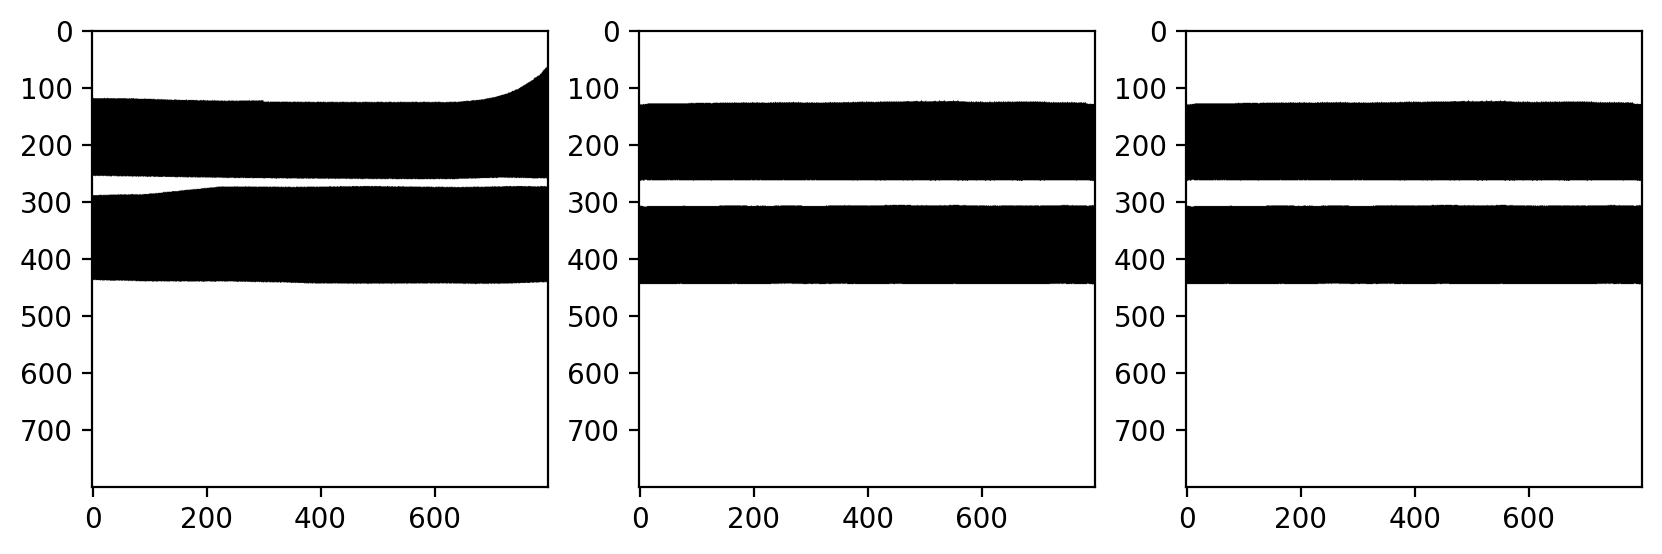

====> Epoch: 1 Average loss: 380713.3155
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.6027771830558777
tensor([[2445632,  544723],
        [ 517597, 1612048]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.6027801036834717
tensor([[2445650,  544705],
        [ 517600, 1612045]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.6041673421859741
tensor([[2463087,  527268],
        [ 524425, 1605220]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.6041716933250427
tensor([[2463108,  527247],
        [ 524426, 1605219]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.6053089499473572
tensor([[2478800,  511555],
        [ 530903, 1598742]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.605309009552002
tensor([[2478802,  511553],
        [ 530904, 1598741]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat Sc

Threat Score: 0.6145031452178955
tensor([[2699791,  290564],
        [ 642419, 1487226]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6145005822181702
tensor([[2700253,  290102],
        [ 642709, 1486936]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.6145010590553284
tensor([[2700263,  290092],
        [ 642714, 1486931]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6144895553588867
tensor([[2700740,  289615],
        [ 643035, 1486610]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.614488959312439
tensor([[2700741,  289614],
        [ 643037, 1486608]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6145012378692627
tensor([[2701196,  289159],
        [ 643287, 1486358]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.6145005822181702
tensor([[2701200,  289155],
        [ 643291, 1486354]], de

Threat Score: 0.5616166591644287
Threat Score: 0.6765962839126587
Threat Score: 0.5982136726379395
Threat Score: 0.6101902723312378
Threat Score: 0.5327523946762085
Threat Score: 0.7021375894546509
Threat Score: 0.6836791038513184
Threat Score: 0.7222533822059631
Threat Score: 0.7281507253646851
Threat Score: 0.7272376418113708
Threat Score: 0.628000795841217
Threat Score: 0.6473480463027954
Threat Score: 0.662178635597229
Threat Score: 0.8301239013671875
Threat Score: 0.6344491839408875
Threat Score: 0.6587746143341064
Threat Score: 0.5550248622894287
Threat Score: 0.7420930862426758
Threat Score: 0.7006751894950867
Threat Score: 0.7267111539840698
Threat Score: 0.606681764125824
Threat Score: 0.600483238697052
Threat Score: 0.7363202571868896
Threat Score: 0.6385225057601929
Threat Score: 0.7460407018661499
Threat Score: 0.5980054140090942
Threat Score: 0.6202394366264343
Threat Score: 0.7553250193595886
Threat Score: 0.6935839056968689
Threat Score: 0.6916157007217407
Threat Score: 

Threat Score: 0.5492182374000549
tensor([[2715362,  534633],
        [ 549334, 1320671]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.55000901222229
tensor([[2726550,  523445],
        [ 553586, 1316419]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.5500140190124512
tensor([[2726570,  523425],
        [ 553585, 1316420]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.5505890846252441
tensor([[2735038,  514957],
        [ 556871, 1313134]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.5505913496017456
tensor([[2735046,  514949],
        [ 556870, 1313135]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.551076352596283
tensor([[2742306,  507689],
        [ 559714, 1310291]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.5510794520378113
tensor([[2742312,  507683],
        [ 559710, 1310295]], devi

Threat Score: 0.5525099039077759
tensor([[2775642,  474353],
        [ 574724, 1295281]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.5525125861167908
tensor([[2775648,  474347],
        [ 574721, 1295284]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.5525364875793457
tensor([[2776057,  473938],
        [ 574891, 1295114]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.5525365471839905
tensor([[2776061,  473934],
        [ 574893, 1295112]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.5525752305984497
tensor([[2776529,  473466],
        [ 575061, 1294944]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.5525742173194885
tensor([[2776532,  473463],
        [ 575065, 1294940]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.5526031255722046
tensor([[2776908,  473087],
        [ 575205, 1294800]], d

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


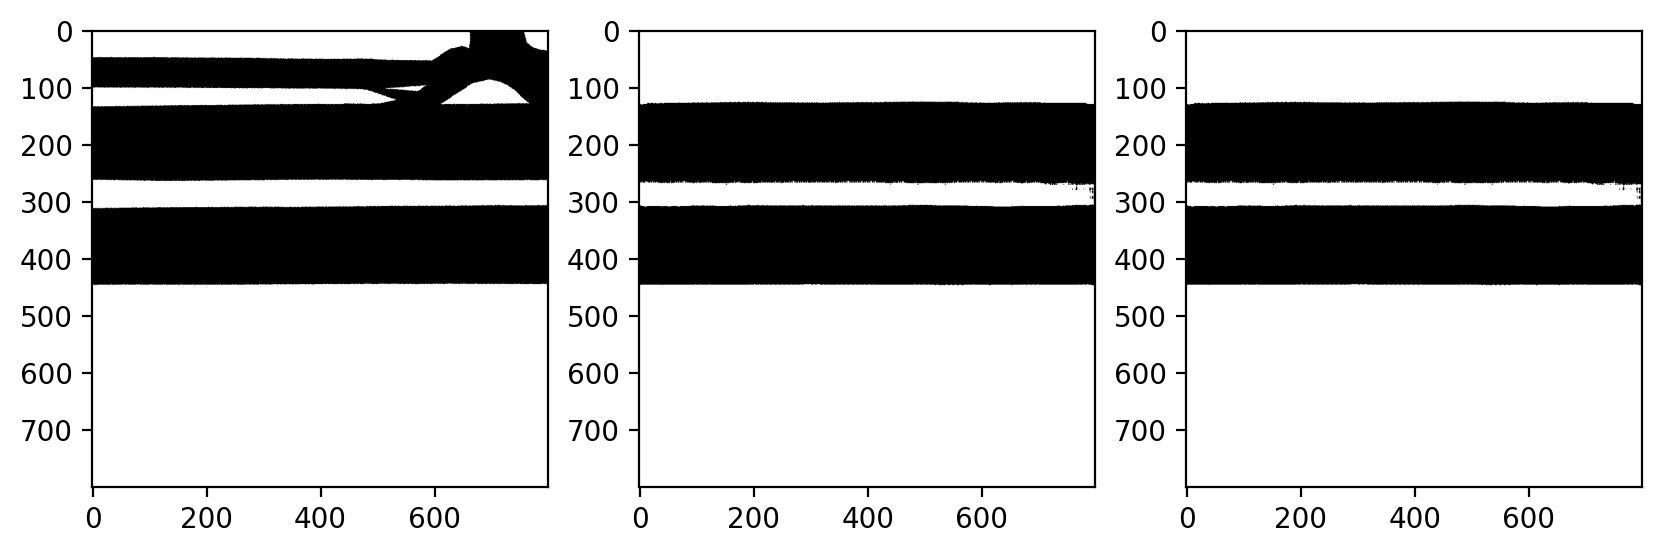

====> Epoch: 2 Average loss: 376434.9613
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.5985263586044312
tensor([[2646378,  620235],
        [ 372859, 1480528]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.5985254049301147
tensor([[2646379,  620234],
        [ 372862, 1480525]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.5990198850631714
tensor([[2653621,  612992],
        [ 375977, 1477410]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.5990199446678162
tensor([[2653623,  612990],
        [ 375978, 1477409]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.5993931293487549
tensor([[2660751,  605862],
        [ 379330, 1474057]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.5993909239768982
tensor([[2660752,  605861],
        [ 379336, 1474051]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat S

Threat Score: 0.6024703979492188
tensor([[2865290,  401323],
        [ 494991, 1358396]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6024153232574463
tensor([[2865655,  400958],
        [ 495335, 1358052]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.6024158596992493
tensor([[2865657,  400956],
        [ 495335, 1358052]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6023776531219482
tensor([[2866027,  400586],
        [ 495644, 1357743]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.6023781895637512
tensor([[2866029,  400584],
        [ 495644, 1357743]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6023356318473816
tensor([[2866381,  400232],
        [ 495952, 1357435]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.602336585521698
tensor([[2866383,  400230],
        [ 495951, 1357436]], de

Threat Score: 0.6038961410522461
Threat Score: 0.6095016002655029
Threat Score: 0.642274796962738
Threat Score: 0.6534332633018494
Threat Score: 0.7075092792510986
Threat Score: 0.6942147612571716
Threat Score: 0.5702372193336487
Threat Score: 0.5428373217582703
Threat Score: 0.6236557960510254
Threat Score: 0.58390212059021
Threat Score: 0.6904714703559875
Threat Score: 0.5216629505157471
Threat Score: 0.5977073907852173
Threat Score: 0.6886796951293945
Threat Score: 0.6228886246681213
Threat Score: 0.598156750202179
Threat Score: 0.6629741191864014
Threat Score: 0.6854982376098633
Threat Score: 0.6172469854354858
Threat Score: 0.7887805104255676
Threat Score: 0.7352532744407654
Threat Score: 0.6535130739212036
Threat Score: 0.674604058265686
Threat Score: 0.5744960308074951
Threat Score: 0.6096988916397095
Threat Score: 0.6196022033691406
Threat Score: 0.7278136014938354
Threat Score: 0.7077542543411255
Threat Score: 0.6366069316864014
Threat Score: 0.626379668712616
Threat Score: 0.

Threat Score: 0.7084047198295593
tensor([[2954104,  363187],
        [ 268378, 1534331]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.7136437892913818
tensor([[2975084,  342207],
        [ 272003, 1530706]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.7136476039886475
tensor([[2975101,  342190],
        [ 272007, 1530702]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.7188936471939087
tensor([[2995989,  321302],
        [ 275771, 1526938]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.7188951969146729
tensor([[2996002,  321289],
        [ 275777, 1526932]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.7238470315933228
tensor([[3015409,  301882],
        [ 279307, 1523402]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.7238520979881287
tensor([[3015432,  301859],
        [ 279313, 1523396]], d

Threat Score: 0.7369732856750488
tensor([[3073759,  243532],
        [ 294684, 1508025]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.7369740009307861
tensor([[3073761,  243530],
        [ 294684, 1508025]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.7370244860649109
tensor([[3074209,  243082],
        [ 294911, 1507798]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.737022876739502
tensor([[3074210,  243081],
        [ 294915, 1507794]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.7370774745941162
tensor([[3074656,  242635],
        [ 295132, 1507577]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.7370765805244446
tensor([[3074659,  242632],
        [ 295136, 1507573]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.7371362447738647
tensor([[3075123,  242168],
        [ 295356, 1507353]], de

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


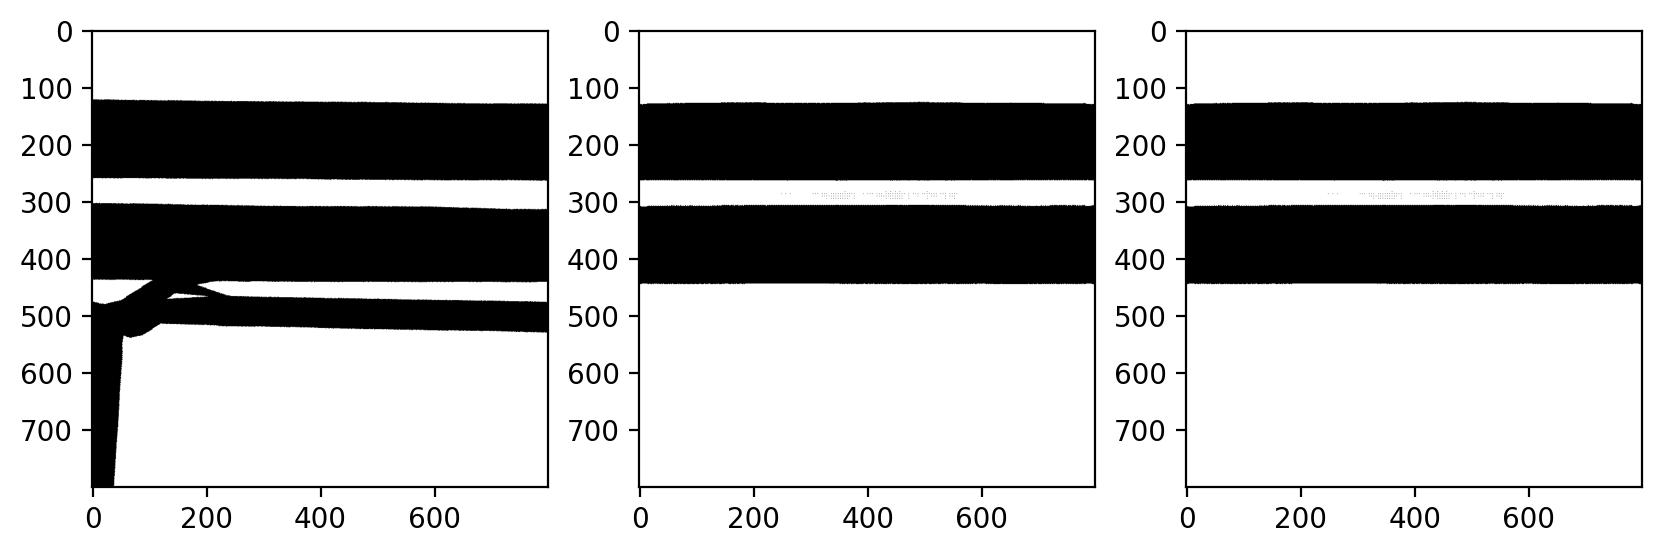

====> Epoch: 3 Average loss: 372530.5914
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.6051604747772217
tensor([[2657830,  596186],
        [ 375976, 1490008]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.6051605939865112
tensor([[2657837,  596179],
        [ 375980, 1490004]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.6053112149238586
tensor([[2660784,  593232],
        [ 377393, 1488591]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.6053118109703064
tensor([[2660788,  593228],
        [ 377394, 1488590]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.6054418087005615
tensor([[2664114,  589902],
        [ 379088, 1486896]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.6054448485374451
tensor([[2664128,  589888],
        [ 379089, 1486895]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat S

Threat Score: 0.6232661008834839
tensor([[2886641,  367375],
        [ 474007, 1391977]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6232703924179077
tensor([[2887006,  367010],
        [ 474225, 1391759]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.6232710480690002
tensor([[2887010,  367006],
        [ 474226, 1391758]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6232794523239136
tensor([[2887414,  366602],
        [ 474459, 1391525]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.6232814788818359
tensor([[2887426,  366590],
        [ 474462, 1391522]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6232897639274597
tensor([[2887807,  366209],
        [ 474681, 1391303]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.6232895255088806
tensor([[2887811,  366205],
        [ 474684, 1391300]], d

Threat Score: 0.6195420622825623
Threat Score: 0.6912813782691956
Threat Score: 0.6502245664596558
Threat Score: 0.6160323023796082
Threat Score: 0.6471746563911438
Threat Score: 0.6876474618911743
Threat Score: 0.6521685123443604
Threat Score: 0.7036218643188477
Threat Score: 0.7257530689239502
Threat Score: 0.7248358726501465
Threat Score: 0.6620708703994751
Threat Score: 0.6542629599571228
Threat Score: 0.6966784596443176
Threat Score: 0.6481500267982483
Threat Score: 0.6345392465591431
Threat Score: 0.5802984237670898
Threat Score: 0.7259220480918884
Threat Score: 0.6986352205276489
Threat Score: 0.5768553018569946
Threat Score: 0.6918944716453552
Threat Score: 0.5345682501792908
Threat Score: 0.6133783459663391
Threat Score: 0.7261788845062256
Threat Score: 0.7538718581199646
Threat Score: 0.5808919072151184
Threat Score: 0.6273099184036255
Threat Score: 0.6003541946411133
Threat Score: 0.6460492610931396
Threat Score: 0.5546486973762512
Threat Score: 0.650103747844696
Threat Scor

Threat Score: 0.566818356513977
tensor([[2603019,  519022],
        [ 571288, 1426671]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.5665342211723328
tensor([[2627748,  494293],
        [ 586013, 1411946]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.5665366053581238
tensor([[2627748,  494293],
        [ 586007, 1411952]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.566494882106781
tensor([[2654811,  467230],
        [ 601442, 1396517]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.5664975047111511
tensor([[2654817,  467224],
        [ 601439, 1396520]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.5666180849075317
tensor([[2679079,  442962],
        [ 614889, 1383070]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.5666190385818481
tensor([[2679083,  442958],
        [ 614889, 1383070]], dev

Threat Score: 0.5679075717926025
tensor([[2734124,  387917],
        [ 643002, 1354957]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.5679075717926025
tensor([[2734124,  387917],
        [ 643002, 1354957]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.5678801536560059
tensor([[2734516,  387525],
        [ 643290, 1354669]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.567880392074585
tensor([[2734517,  387524],
        [ 643290, 1354669]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.5678454041481018
tensor([[2734886,  387155],
        [ 643583, 1354376]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.5678436756134033
tensor([[2734884,  387157],
        [ 643586, 1354373]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.5678048133850098
tensor([[2735235,  386806],
        [ 643878, 1354081]], de

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


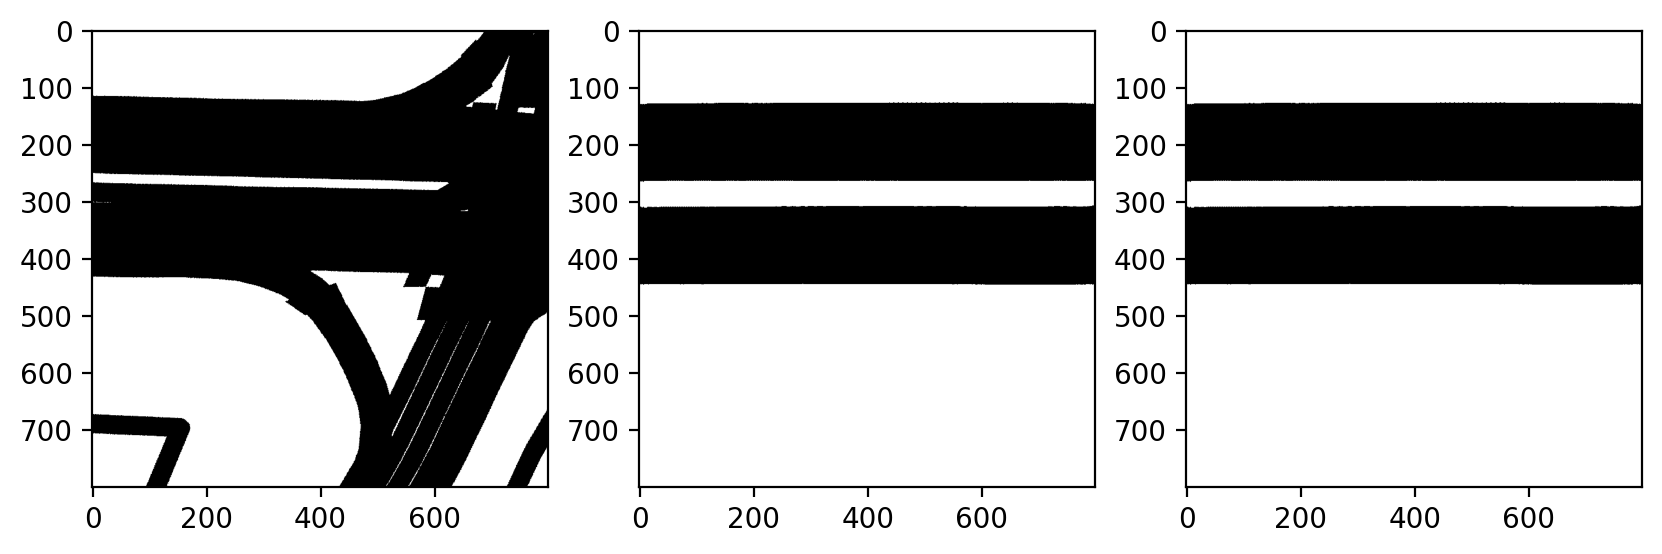

====> Epoch: 4 Average loss: 369307.1996
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.7007492780685425
tensor([[2446349,  213580],
        [ 586512, 1873559]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.7007489204406738
tensor([[2446349,  213580],
        [ 586513, 1873558]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.7007543444633484
tensor([[2447510,  212419],
        [ 587312, 1872759]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.7007544636726379
tensor([[2447509,  212420],
        [ 587311, 1872760]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.7007681727409363
tensor([[2448767,  211162],
        [ 588156, 1871915]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.7007678747177124
tensor([[2448763,  211166],
        [ 588154, 1871917]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat S

Threat Score: 0.6850045323371887
tensor([[2607024,   52905],
        [ 738671, 1721400]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6849676370620728
tensor([[2607344,   52585],
        [ 738983, 1721088]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.6849665641784668
tensor([[2607343,   52586],
        [ 738985, 1721086]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6849491596221924
tensor([[2607704,   52225],
        [ 739276, 1720795]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.6849475502967834
tensor([[2607701,   52228],
        [ 739278, 1720793]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6849151253700256
tensor([[2608007,   51922],
        [ 739569, 1720502]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.6849145889282227
tensor([[2608005,   51924],
        [ 739569, 1720502]], d

Threat Score: 0.7742205262184143
Threat Score: 0.590069055557251
Threat Score: 0.6582920551300049
Threat Score: 0.6476479768753052
Threat Score: 0.70457524061203
Threat Score: 0.5794590711593628
Threat Score: 0.7702158689498901
Threat Score: 0.599291980266571
Threat Score: 0.6236623525619507
Threat Score: 0.6697291731834412
Threat Score: 0.7679494619369507
Threat Score: 0.6422224044799805
Threat Score: 0.63120037317276
Threat Score: 0.652940571308136
Threat Score: 0.6027722358703613
Threat Score: 0.6951035857200623
Threat Score: 0.7029748558998108
Threat Score: 0.6312548518180847
Threat Score: 0.5967740416526794
Threat Score: 0.7655323147773743
Threat Score: 0.5723283886909485
Threat Score: 0.6454074382781982
Threat Score: 0.6588512659072876
Threat Score: 0.6259893774986267
Threat Score: 0.5908323526382446
Threat Score: 0.7385079264640808
Threat Score: 0.6876992583274841
Threat Score: 0.5734105110168457
Threat Score: 0.6368314623832703
Threat Score: 0.6674758195877075
Threat Score: 0.5

Threat Score: 0.6823248267173767
tensor([[2502493,  263744],
        [ 567773, 1785990]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.6786257028579712
tensor([[2511954,  254283],
        [ 583876, 1769887]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.6786265969276428
tensor([[2511956,  254281],
        [ 583875, 1769888]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.6731776595115662
tensor([[2528381,  237856],
        [ 609143, 1744620]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.67317795753479
tensor([[2528391,  237846],
        [ 609149, 1744614]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.6674490571022034
tensor([[2550508,  215729],
        [ 638758, 1715005]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.6674500703811646
tensor([[2550515,  215722],
        [ 638760, 1715003]], dev

Threat Score: 0.6538454294204712
tensor([[2632744,  133493],
        [ 727482, 1626281]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.6538462042808533
tensor([[2632747,  133490],
        [ 727482, 1626281]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.6537768244743347
tensor([[2633000,  133237],
        [ 727820, 1625943]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.6537780165672302
tensor([[2633003,  133234],
        [ 727819, 1625944]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.6537107825279236
tensor([[2633275,  132962],
        [ 728164, 1625599]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.653708815574646
tensor([[2633275,  132962],
        [ 728169, 1625594]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.6536432504653931
tensor([[2633535,  132702],
        [ 728502, 1625261]], de

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


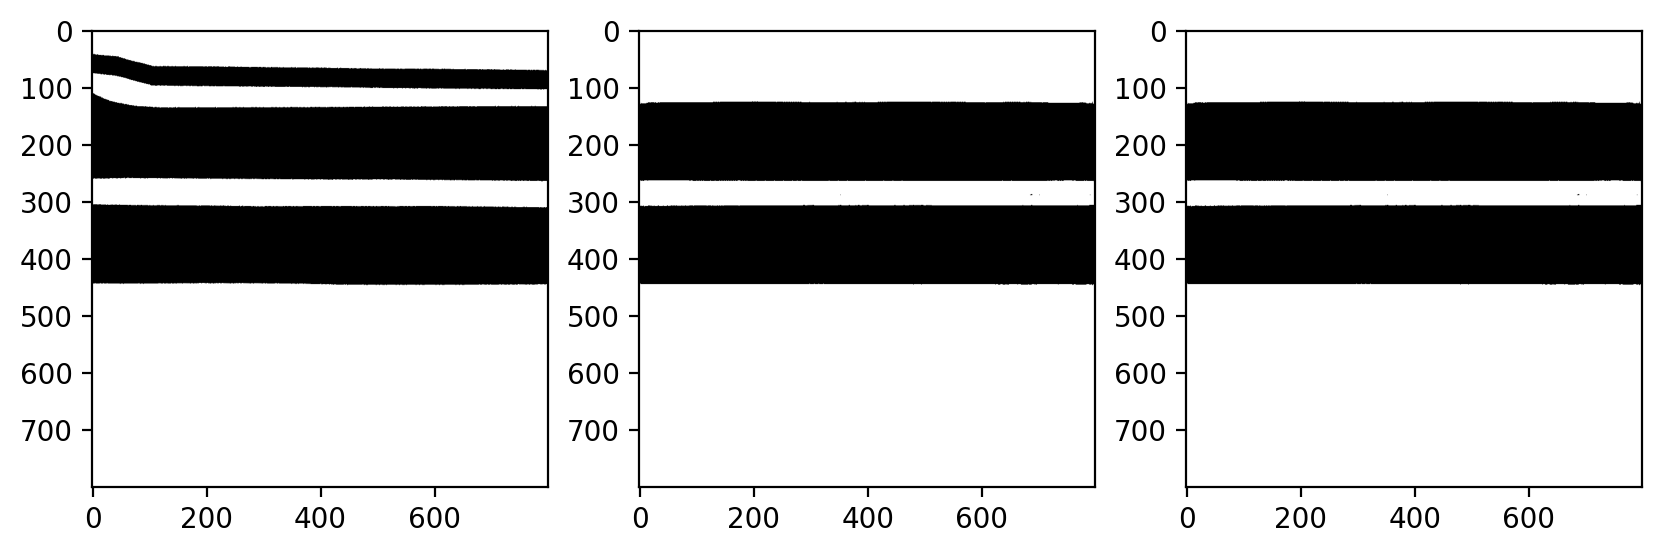

====> Epoch: 5 Average loss: 366525.2283
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.5376758575439453
tensor([[2565379,  679792],
        [ 501271, 1373558]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.5376797914505005
tensor([[2565407,  679764],
        [ 501276, 1373553]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.5381764769554138
tensor([[2570394,  674777],
        [ 502691, 1372138]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.5381821990013123
tensor([[2570423,  674748],
        [ 502692, 1372137]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.5387389063835144
tensor([[2575788,  669383],
        [ 504163, 1370666]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.5387469530105591
tensor([[2575824,  669347],
        [ 504162, 1370667]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat S

Threat Score: 0.5639927983283997
tensor([[2793355,  451816],
        [ 562618, 1312211]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.5639898180961609
tensor([[2793621,  451550],
        [ 562775, 1312054]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.5639885067939758
tensor([[2793621,  451550],
        [ 562778, 1312051]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.5639845132827759
tensor([[2793922,  451249],
        [ 562957, 1311872]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.5639848113059998
tensor([[2793925,  451246],
        [ 562958, 1311871]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.5639891624450684
tensor([[2794232,  450939],
        [ 563121, 1311708]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.5639893412590027
tensor([[2794238,  450933],
        [ 563124, 1311705]], d

Threat Score: 0.6312057375907898
Threat Score: 0.6028944849967957
Threat Score: 0.6247909069061279
Threat Score: 0.6003732085227966
Threat Score: 0.6344099044799805
Threat Score: 0.7906612157821655
Threat Score: 0.7102402448654175
Threat Score: 0.6624342799186707
Threat Score: 0.5318114757537842
Threat Score: 0.5789267420768738
Threat Score: 0.6125922799110413
Threat Score: 0.6689411997795105
Threat Score: 0.6755449771881104
Threat Score: 0.6823536157608032
Threat Score: 0.6443825960159302
Threat Score: 0.7716360688209534
Threat Score: 0.7200567126274109
Threat Score: 0.5715965032577515
Threat Score: 0.6499562859535217
Threat Score: 0.6791871190071106
Threat Score: 0.5753740072250366
Threat Score: 0.6965943574905396
Threat Score: 0.6087936162948608
Threat Score: 0.6647145748138428
Threat Score: 0.6673596501350403
Threat Score: 0.6244108080863953
Threat Score: 0.6852709054946899
Threat Score: 0.7842323184013367
Threat Score: 0.563267171382904
Threat Score: 0.6267680525779724
Threat Scor

Threat Score: 0.651976466178894
tensor([[2546829,  161948],
        [ 733576, 1677647]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.6498157382011414
tensor([[2556141,  152636],
        [ 745187, 1666036]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.6498146057128906
tensor([[2556144,  152633],
        [ 745192, 1666031]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.6484147906303406
tensor([[2563516,  145261],
        [ 753561, 1657662]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.6484132409095764
tensor([[2563527,  145250],
        [ 753572, 1657651]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.6475259065628052
tensor([[2569177,  139600],
        [ 759499, 1651724]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.6475252509117126
tensor([[2569179,  139598],
        [ 759502, 1651721]], de

Threat Score: 0.6448896527290344
tensor([[2594078,  114699],
        [ 782282, 1628941]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.64488685131073
tensor([[2594081,  114696],
        [ 782291, 1628932]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.6448072195053101
tensor([[2594349,  114428],
        [ 782665, 1628558]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.6448034048080444
tensor([[2594351,  114426],
        [ 782676, 1628547]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.6447263360023499
tensor([[2594623,  114154],
        [ 783046, 1628177]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.6447237730026245
tensor([[2594630,  114147],
        [ 783057, 1628166]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.6446438431739807
tensor([[2594863,  113914],
        [ 783409, 1627814]], dev

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


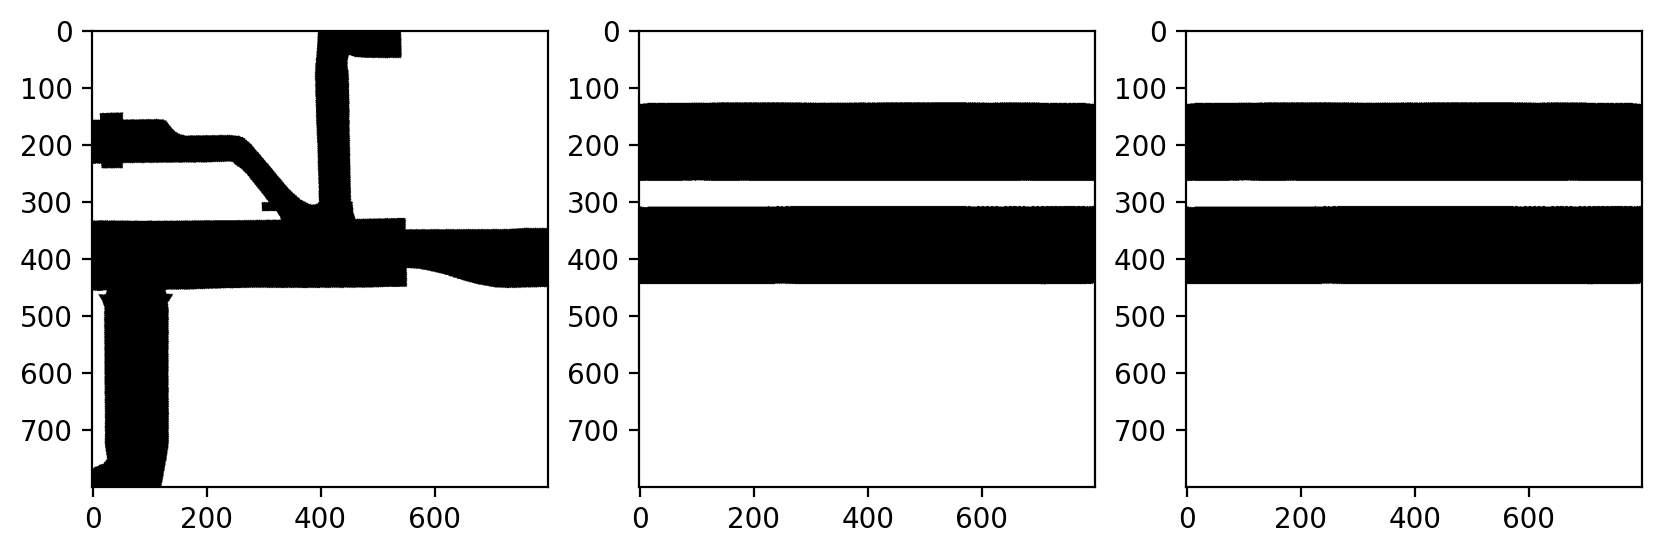

====> Epoch: 6 Average loss: 364229.8481
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.6458015441894531
tensor([[2686912,  500889],
        [ 360907, 1571292]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.645801842212677
tensor([[2686913,  500888],
        [ 360907, 1571292]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.6459388732910156
tensor([[2688081,  499720],
        [ 361328, 1570871]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.6459372639656067
tensor([[2688078,  499723],
        [ 361330, 1570869]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.646064281463623
tensor([[2689231,  498570],
        [ 361766, 1570433]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.6460639834403992
tensor([[2689230,  498571],
        [ 361766, 1570433]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat Sco

Threat Score: 0.6688159704208374
tensor([[2903924,  283877],
        [ 450052, 1482147]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6688104271888733
tensor([[2904118,  283683],
        [ 450194, 1482005]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.668809711933136
tensor([[2904120,  283681],
        [ 450197, 1482002]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6688172221183777
tensor([[2904317,  283484],
        [ 450312, 1481887]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.668817400932312
tensor([[2904319,  283482],
        [ 450313, 1481886]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6688320636749268
tensor([[2904529,  283272],
        [ 450421, 1481778]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.6688323616981506
tensor([[2904530,  283271],
        [ 450421, 1481778]], dev

Threat Score: 0.650543749332428
Threat Score: 0.6094914078712463
Threat Score: 0.5868078470230103
Threat Score: 0.6353169083595276
Threat Score: 0.71869957447052
Threat Score: 0.6944110989570618
Threat Score: 0.6067954301834106
Threat Score: 0.6591785550117493
Threat Score: 0.6290833950042725
Threat Score: 0.7230353951454163
Threat Score: 0.6387781500816345
Threat Score: 0.7515369057655334
Threat Score: 0.6631426811218262
Threat Score: 0.6187427043914795
Threat Score: 0.7044460773468018
Threat Score: 0.729926347732544
Threat Score: 0.6573362350463867
Threat Score: 0.6580917835235596
Threat Score: 0.8074007034301758
Threat Score: 0.6129755973815918
Threat Score: 0.6683244705200195
Threat Score: 0.6066237688064575
Threat Score: 0.5526163578033447
Threat Score: 0.6498507857322693
Threat Score: 0.6471977829933167
Threat Score: 0.7199881672859192
Threat Score: 0.5487105846405029
Threat Score: 0.6084657311439514
Threat Score: 0.6756139993667603
Threat Score: 0.6920853853225708
Threat Score: 

Threat Score: 0.6762691736221313
tensor([[2628915,  295100],
        [ 511341, 1684644]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.6798713207244873
tensor([[2657690,  266325],
        [ 521931, 1674054]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.6798751354217529
tensor([[2657717,  266298],
        [ 521940, 1674045]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.6837353110313416
tensor([[2692081,  231934],
        [ 535931, 1660054]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.6837355494499207
tensor([[2692111,  231904],
        [ 535951, 1660034]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.6864479780197144
tensor([[2722283,  201732],
        [ 550077, 1645908]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.68644779920578
tensor([[2722310,  201705],
        [ 550096, 1645889]], dev

Threat Score: 0.6914211511611938
tensor([[2789691,  134324],
        [ 584760, 1611225]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.691419780254364
tensor([[2789695,  134320],
        [ 584766, 1611219]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.6914096474647522
tensor([[2790018,  133997],
        [ 585013, 1610972]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.6914105415344238
tensor([[2790024,  133991],
        [ 585015, 1610970]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.6914044618606567
tensor([[2790368,  133647],
        [ 585267, 1610718]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.6914047002792358
tensor([[2790373,  133642],
        [ 585270, 1610715]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.691379725933075
tensor([[2790707,  133308],
        [ 585559, 1610426]], dev

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


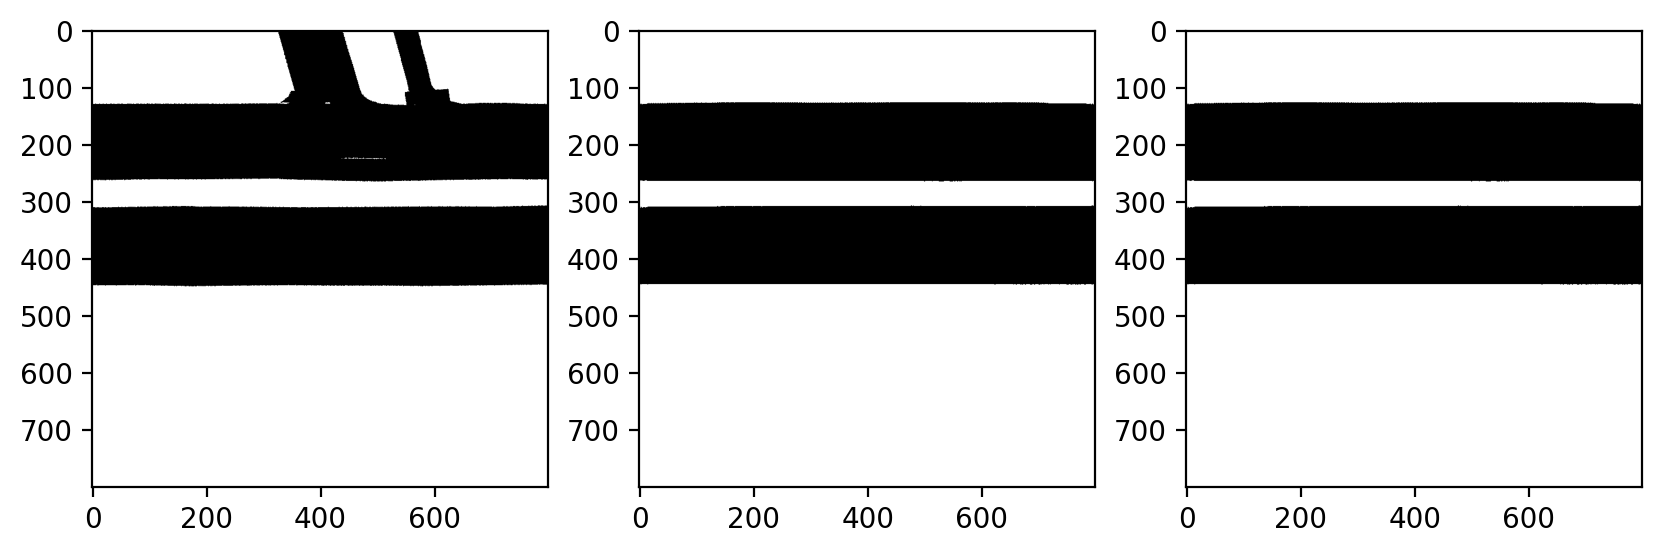

====> Epoch: 7 Average loss: 362022.1459
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.6929087042808533
tensor([[2660500,  368617],
        [ 386674, 1704209]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.6929078698158264
tensor([[2660484,  368633],
        [ 386665, 1704218]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.6930453181266785
tensor([[2661634,  367483],
        [ 387124, 1703759]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.6930432319641113
tensor([[2661621,  367496],
        [ 387120, 1703763]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.6931931972503662
tensor([[2662737,  366380],
        [ 387525, 1703358]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.6931909918785095
tensor([[2662722,  366395],
        [ 387520, 1703363]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat S

Threat Score: 0.7091442942619324
tensor([[2875392,  153725],
        [ 499132, 1591751]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.7091286182403564
tensor([[2875654,  153463],
        [ 499353, 1591530]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.7091264724731445
tensor([[2875643,  153474],
        [ 499350, 1591533]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.7091019153594971
tensor([[2875836,  153281],
        [ 499542, 1591341]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.7091038227081299
tensor([[2875828,  153289],
        [ 499532, 1591351]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.7090926766395569
tensor([[2876038,  153079],
        [ 499706, 1591177]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.7090919017791748
tensor([[2876030,  153087],
        [ 499702, 1591181]], d

Threat Score: 0.6097965240478516
Threat Score: 0.6404860615730286
Threat Score: 0.6713416576385498
Threat Score: 0.5572397708892822
Threat Score: 0.6635102033615112
Threat Score: 0.6924653649330139
Threat Score: 0.7082155346870422
Threat Score: 0.6985833048820496
Threat Score: 0.7038840651512146
Threat Score: 0.7053435444831848
Threat Score: 0.5623943209648132
Threat Score: 0.6856883764266968
Threat Score: 0.6778108477592468
Threat Score: 0.5130981206893921
Threat Score: 0.6253780722618103
Threat Score: 0.686323881149292
Threat Score: 0.639729380607605
Threat Score: 0.6436997652053833
Threat Score: 0.5710012912750244
Threat Score: 0.646911084651947
Threat Score: 0.7873737812042236
Threat Score: 0.6508219838142395
Threat Score: 0.6533478498458862
Threat Score: 0.7487033009529114
Threat Score: 0.6394035220146179
Threat Score: 0.6380433440208435
Threat Score: 0.6575853824615479
Threat Score: 0.5820438265800476
Threat Score: 0.6390416622161865
Threat Score: 0.6418761014938354
Threat Score:

Threat Score: 0.5738983750343323
tensor([[2607231,  419719],
        [ 650976, 1442074]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.5740734934806824
tensor([[2629305,  397645],
        [ 663208, 1429842]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.5740745067596436
tensor([[2629252,  397698],
        [ 663175, 1429875]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.5736308693885803
tensor([[2644591,  382359],
        [ 673079, 1419971]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.5736358165740967
tensor([[2644553,  382397],
        [ 673045, 1420005]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.5729154944419861
tensor([[2653528,  373422],
        [ 679970, 1413080]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.572917640209198
tensor([[2653504,  373446],
        [ 679951, 1413099]], de

Threat Score: 0.5717772245407104
tensor([[2680793,  346157],
        [ 698367, 1394683]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.5717817544937134
tensor([[2680786,  346164],
        [ 698352, 1394698]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.5717284679412842
tensor([[2680975,  345975],
        [ 698590, 1394460]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.5717275738716125
tensor([[2680959,  345991],
        [ 698583, 1394467]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.5716759562492371
tensor([[2681162,  345788],
        [ 698825, 1394225]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.5716801285743713
tensor([[2681152,  345798],
        [ 698809, 1394241]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.571621835231781
tensor([[2681379,  345571],
        [ 699081, 1393969]], de

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


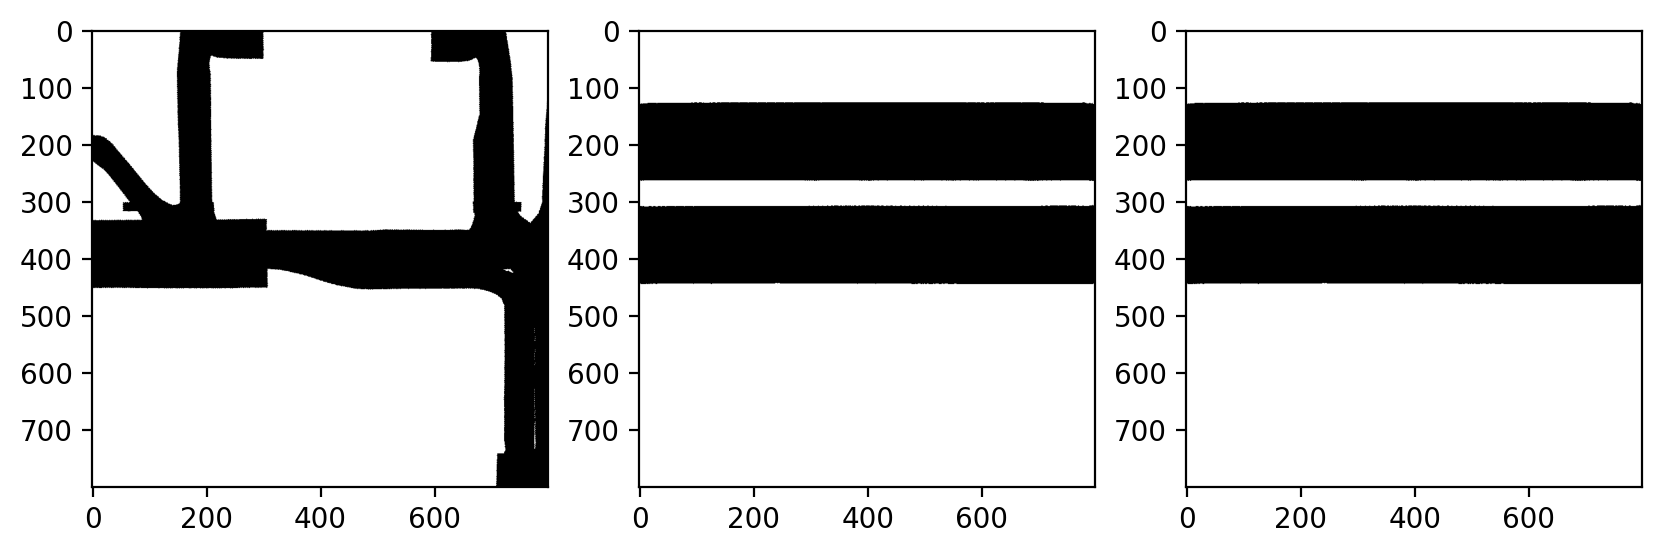

====> Epoch: 8 Average loss: 360303.8434
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.6637156009674072
tensor([[2540692,  368079],
        [ 499302, 1711927]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.6637144684791565
tensor([[2540692,  368079],
        [ 499305, 1711924]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.6637306809425354
tensor([[2541317,  367454],
        [ 499678, 1711551]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.6637300252914429
tensor([[2541319,  367452],
        [ 499681, 1711548]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.6637348532676697
tensor([[2541939,  366832],
        [ 500080, 1711149]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.663735032081604
tensor([[2541941,  366830],
        [ 500081, 1711148]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat Sc

Threat Score: 0.6785144209861755
tensor([[2757611,  151160],
        [ 608314, 1602915]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6785054802894592
tensor([[2757857,  150914],
        [ 608502, 1602727]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.6785049438476562
tensor([[2757858,  150913],
        [ 608504, 1602725]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6784951090812683
tensor([[2758092,  150679],
        [ 608686, 1602543]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.6784964203834534
tensor([[2758098,  150673],
        [ 608687, 1602542]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6784842014312744
tensor([[2758340,  150431],
        [ 608880, 1602349]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.6784833669662476
tensor([[2758343,  150428],
        [ 608884, 1602345]], d

Threat Score: 0.5639872550964355
Threat Score: 0.4853440821170807
Threat Score: 0.6444758176803589
Threat Score: 0.6030999422073364
Threat Score: 0.7152976393699646
Threat Score: 0.6763110160827637
Threat Score: 0.6553026437759399
Threat Score: 0.637129008769989
Threat Score: 0.6589187979698181
Threat Score: 0.6874753832817078
Threat Score: 0.6639062166213989
Threat Score: 0.7128708362579346
Threat Score: 0.6863711476325989
Threat Score: 0.7658306360244751
Threat Score: 0.5529139041900635
Threat Score: 0.6510175466537476
Threat Score: 0.6905443072319031
Threat Score: 0.647229015827179
Threat Score: 0.5677042603492737
Threat Score: 0.584243893623352
Threat Score: 0.8358416557312012
Threat Score: 0.816025972366333
Threat Score: 0.5612431764602661
Threat Score: 0.6002038717269897
Threat Score: 0.6700602173805237
Threat Score: 0.6233152747154236
Threat Score: 0.6446200013160706
Threat Score: 0.7131360769271851
Threat Score: 0.5899733304977417
Threat Score: 0.6315074563026428
Threat Score: 

Threat Score: 0.650483250617981
tensor([[2729362,  394245],
        [ 441323, 1555070]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.6546001434326172
tensor([[2761994,  361613],
        [ 452842, 1543551]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.6546016931533813
tensor([[2762018,  361589],
        [ 452854, 1543539]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.6578976511955261
tensor([[2792369,  331238],
        [ 465050, 1531343]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.6578948497772217
tensor([[2792388,  331219],
        [ 465069, 1531324]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.6599003076553345
tensor([[2816405,  307202],
        [ 476250, 1520143]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.6598992347717285
tensor([[2816412,  307195],
        [ 476257, 1520136]], de

Threat Score: 0.6636397838592529
tensor([[2869166,  254441],
        [ 502650, 1493743]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.6636402010917664
tensor([[2869169,  254438],
        [ 502651, 1493742]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.6636123061180115
tensor([[2869430,  254177],
        [ 502887, 1493506]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.6636102795600891
tensor([[2869432,  254175],
        [ 502893, 1493500]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.6635919213294983
tensor([[2869721,  253886],
        [ 503126, 1493267]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.6635915040969849
tensor([[2869724,  253883],
        [ 503129, 1493264]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.6635622382164001
tensor([[2869994,  253613],
        [ 503374, 1493019]], d

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


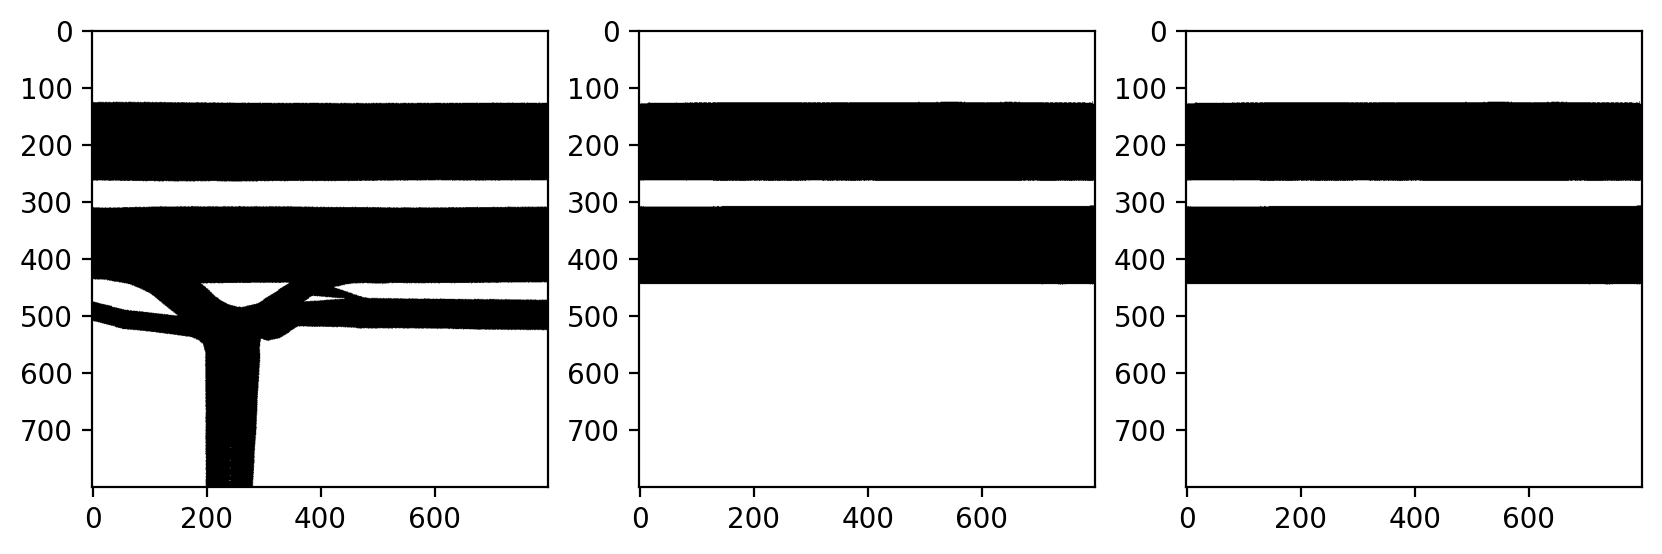

====> Epoch: 9 Average loss: 358681.9412
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.5334696173667908
tensor([[2399847,  612949],
        [ 656085, 1451119]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.5334667563438416
tensor([[2399838,  612958],
        [ 656088, 1451116]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.5333883762359619
tensor([[2401885,  610911],
        [ 657393, 1449811]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.533385157585144
tensor([[2401876,  610920],
        [ 657397, 1449807]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.533305287361145
tensor([[2404439,  608357],
        [ 658981, 1448223]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.5333027839660645
tensor([[2404432,  608364],
        [ 658984, 1448220]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat Sco

Threat Score: 0.5207866430282593
tensor([[2584042,  428754],
        [ 786511, 1320693]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.5207576155662537
tensor([[2584206,  428590],
        [ 786670, 1320534]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.5207566022872925
tensor([[2584203,  428593],
        [ 786671, 1320533]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.5207236409187317
tensor([[2584348,  428448],
        [ 786830, 1320374]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.5207228660583496
tensor([[2584346,  428450],
        [ 786831, 1320373]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.5206807851791382
tensor([[2584483,  428313],
        [ 787009, 1320195]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.520679771900177
tensor([[2584482,  428314],
        [ 787011, 1320193]], de

Threat Score: 0.7100419402122498
Threat Score: 0.5862448811531067
Threat Score: 0.6756443381309509
Threat Score: 0.6149935126304626
Threat Score: 0.708391010761261
Threat Score: 0.6835375428199768
Threat Score: 0.5950771570205688
Threat Score: 0.5566279888153076
Threat Score: 0.7887628078460693
Threat Score: 0.7008267641067505
Threat Score: 0.6961921453475952
Threat Score: 0.6688223481178284
Threat Score: 0.7145214080810547
Threat Score: 0.6336360573768616
Threat Score: 0.6206032633781433
Threat Score: 0.6714341640472412
Threat Score: 0.6591578722000122
Threat Score: 0.6970658898353577
Threat Score: 0.6906794905662537
Threat Score: 0.6979374885559082
Threat Score: 0.6455615162849426
Threat Score: 0.65695720911026
Threat Score: 0.6343249678611755
Threat Score: 0.5746021270751953
Threat Score: 0.5535762906074524
Threat Score: 0.6329485774040222
Threat Score: 0.669130802154541
Threat Score: 0.6689640879631042
Threat Score: 0.6261492967605591
Threat Score: 0.7282422184944153
Threat Score: 

Threat Score: 0.6868258118629456
tensor([[2717468,  213669],
        [ 538742, 1650121]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.6854240298271179
tensor([[2732780,  198357],
        [ 552605, 1636258]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.6854274868965149
tensor([[2732773,  198364],
        [ 552592, 1636271]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.6836225986480713
tensor([[2744192,  186945],
        [ 564707, 1624156]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.6836257576942444
tensor([[2744187,  186950],
        [ 564696, 1624167]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.6826024055480957
tensor([[2752030,  179107],
        [ 572481, 1616382]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.6826047897338867
tensor([[2752028,  179109],
        [ 572474, 1616389]], d

Threat Score: 0.680659830570221
tensor([[2778641,  152496],
        [ 595194, 1593669]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.6806602478027344
tensor([[2778638,  152499],
        [ 595191, 1593672]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.6805674433708191
tensor([[2778808,  152329],
        [ 595524, 1593339]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.6805679798126221
tensor([[2778804,  152333],
        [ 595520, 1593343]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.6804711818695068
tensor([[2778953,  152184],
        [ 595848, 1593015]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.6804702877998352
tensor([[2778947,  152190],
        [ 595846, 1593017]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.6803851127624512
tensor([[2779114,  152023],
        [ 596159, 1592704]], de

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


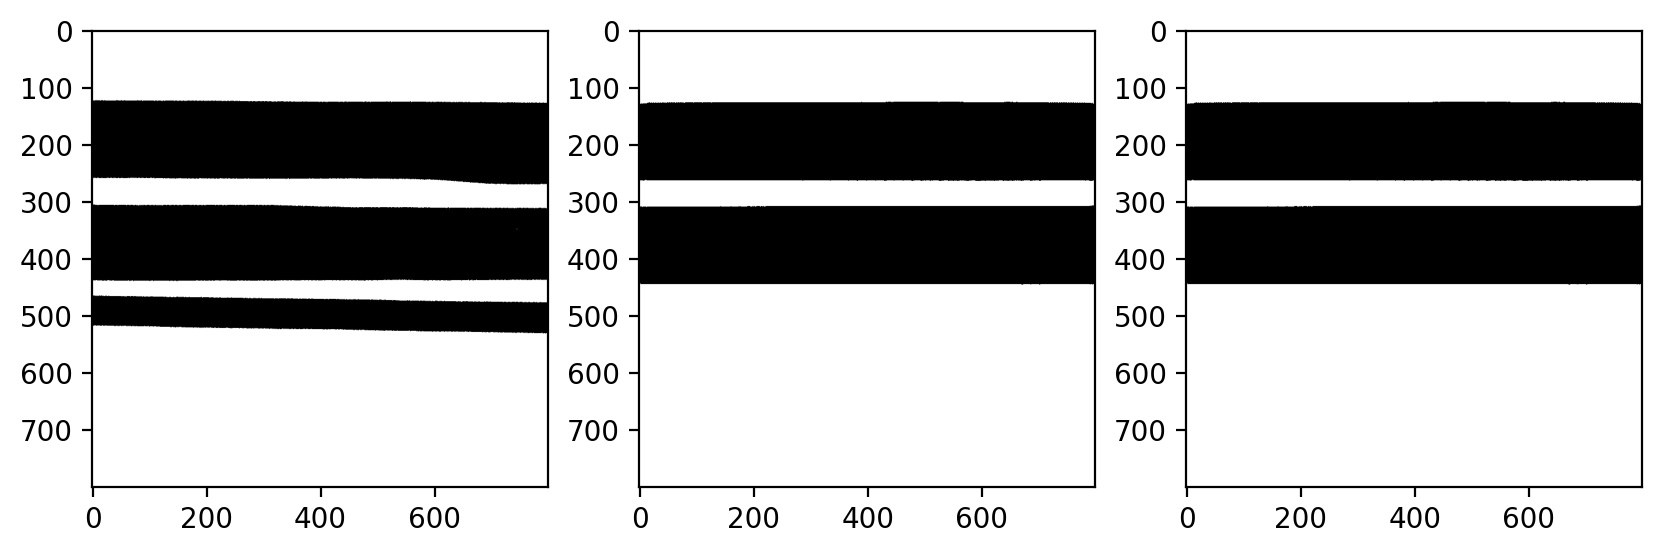

====> Epoch: 10 Average loss: 357294.1840
Confusion Matrix (Post) at threshold: 0.48
Threat Score: 0.639572262763977
tensor([[2571406,  436976],
        [ 481608, 1630010]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.48
Threat Score: 0.6395723223686218
tensor([[2571414,  436968],
        [ 481613, 1630005]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.481
Threat Score: 0.6397521495819092
tensor([[2572973,  435409],
        [ 482152, 1629466]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.481
Threat Score: 0.6397556066513062
tensor([[2572993,  435389],
        [ 482156, 1629462]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.482
Threat Score: 0.6399449110031128
tensor([[2574670,  433712],
        [ 482747, 1628871]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.482
Threat Score: 0.6399474740028381
tensor([[2574688,  433694],
        [ 482752, 1628866]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.483
Threat S

Threat Score: 0.6772630214691162
tensor([[2816623,  191759],
        [ 551626, 1559992]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.501
Threat Score: 0.6772510409355164
tensor([[2816919,  191463],
        [ 551854, 1559764]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.501
Threat Score: 0.6772500276565552
tensor([[2816923,  191459],
        [ 551859, 1559759]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.502
Threat Score: 0.6772487759590149
tensor([[2817220,  191162],
        [ 552063, 1559555]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.502
Threat Score: 0.6772457957267761
tensor([[2817223,  191159],
        [ 552072, 1559546]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.503
Threat Score: 0.6772453784942627
tensor([[2817477,  190905],
        [ 552245, 1559373]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.503
Threat Score: 0.6772433519363403
tensor([[2817479,  190903],
        [ 552251, 1559367]], d

Threat Score: 0.6179811954498291
Threat Score: 0.7641686797142029
Threat Score: 0.6740896701812744
Threat Score: 0.6740254759788513
Threat Score: 0.6402899622917175
Threat Score: 0.7072410583496094
Threat Score: 0.6438066363334656
Threat Score: 0.6823747158050537
Threat Score: 0.6533507108688354
Threat Score: 0.6507278084754944
Threat Score: 0.6337066292762756
Threat Score: 0.4997519552707672
Threat Score: 0.6892989277839661
Threat Score: 0.7360740900039673
Threat Score: 0.5845628380775452
Threat Score: 0.5751289129257202
Threat Score: 0.6451894044876099
Threat Score: 0.6946664452552795
Threat Score: 0.6403731107711792
Threat Score: 0.697084903717041
Threat Score: 0.5590636134147644
Threat Score: 0.6376639604568481
Threat Score: 0.6765576004981995
Threat Score: 0.6733886003494263
Threat Score: 0.6572431325912476
Threat Score: 0.7745787501335144
Threat Score: 0.708816409111023
Threat Score: 0.7391955256462097
Threat Score: 0.7994344830513
Threat Score: 0.6440220475196838
Threat Score: 0

Threat Score: 0.7090560793876648
tensor([[2832683,  254065],
        [ 411416, 1621836]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.493
Threat Score: 0.7139467000961304
tensor([[2856796,  229952],
        [ 417445, 1615807]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.493
Threat Score: 0.7139596939086914
tensor([[2856833,  229915],
        [ 417442, 1615810]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.494
Threat Score: 0.7181189656257629
tensor([[2878150,  208598],
        [ 423337, 1609915]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.494
Threat Score: 0.7181276082992554
tensor([[2878177,  208571],
        [ 423337, 1609915]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.495
Threat Score: 0.7207221388816833
tensor([[2893053,  193695],
        [ 428242, 1605010]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.495
Threat Score: 0.7207298874855042
tensor([[2893070,  193678],
        [ 428237, 1605015]], d

Threat Score: 0.7270129919052124
tensor([[2932200,  154548],
        [ 442693, 1590559]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.513
Threat Score: 0.7270150780677795
tensor([[2932209,  154539],
        [ 442695, 1590557]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.514
Threat Score: 0.7270326018333435
tensor([[2932464,  154284],
        [ 442842, 1590410]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.514
Threat Score: 0.7270360589027405
tensor([[2932473,  154275],
        [ 442841, 1590411]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.515
Threat Score: 0.727043628692627
tensor([[2932720,  154028],
        [ 443004, 1590248]], device='cuda:0')
Confusion Matrix (Prior) at threshold: 0.515
Threat Score: 0.7270464897155762
tensor([[2932730,  154018],
        [ 443005, 1590247]], device='cuda:0')
Confusion Matrix (Post) at threshold: 0.516
Threat Score: 0.7270447015762329
tensor([[2932986,  153762],
        [ 443195, 1590057]], de

/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022027550/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


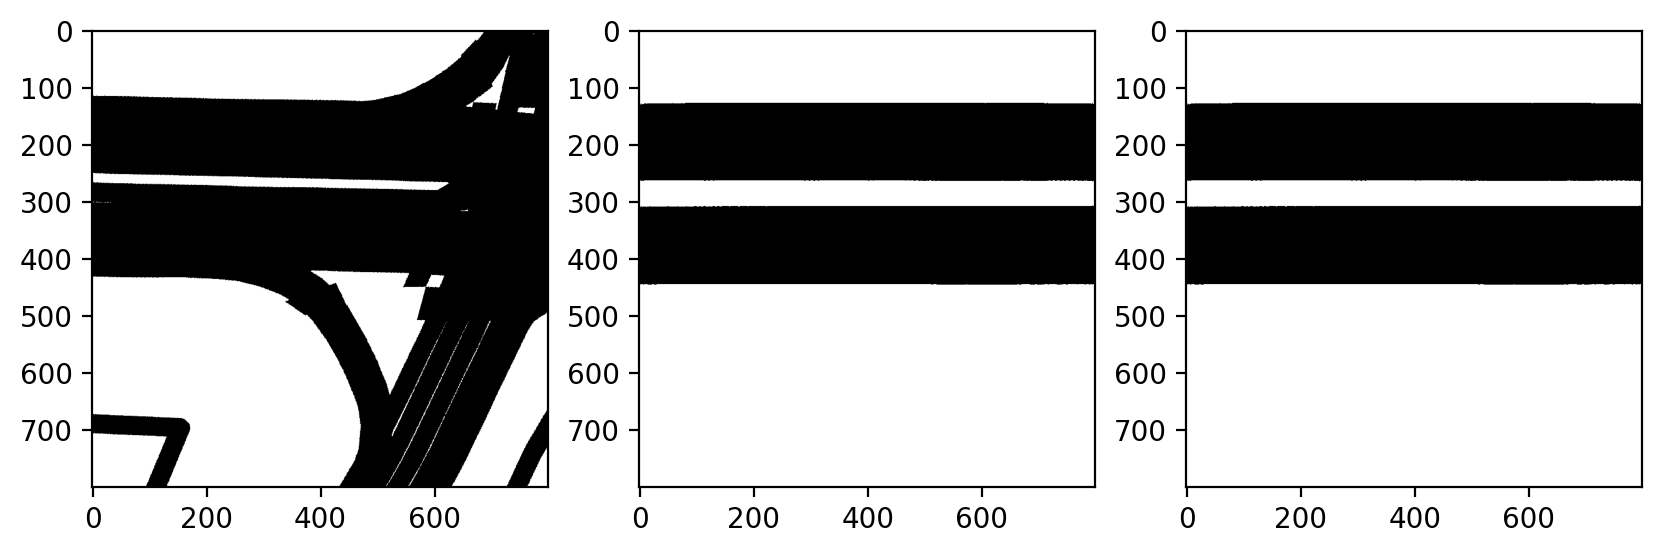

In [38]:
# Training and testing the VAE

accuracy_list = []
threshold = 0.5
epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch >= 0:  # test untrained net first
        model.train()
        train_loss = 0
        for i, data in enumerate(trainloader):
            sample, target, road_image, extra = data
            x = 1.0*torch.stack(road_image).reshape(-1, 1, 800, 800).to(device)
            batch_size = x.size(0)
            y = torch.stack(sample).reshape(6,-1,3,256,256).to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x, y)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(trainloader.dataset):.4f}')

    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss_post = 0
        test_loss_prior = 0
        road_correct_post = 0
        road_correct_prior = 0
        total_road = 0
        conf_matrix_road = torch.zeros(2,2).to(device)
        for batch_idx, data in enumerate(testloader):
            sample, target, road_image, extra = data
            x = 1.0*torch.stack(road_image).reshape(-1, 1, 800, 800).to(device)
            batch_size = x.size(0)
            y = torch.stack(sample).reshape(6,-1,3,256,256).to(device)
            
            # ===================forward=====================
            mu = torch.mean(mu,0).repeat(batch_size).view(batch_size,196)
            logvar = torch.mean(logvar,0).repeat(batch_size).view(batch_size,196)
            x_hat_post = model.inference(y, mu, logvar)
            x_hat_prior = model.inference(y)
            test_loss_post += loss_function(x_hat_post, x, mu, logvar).item()
            test_loss_prior += loss_function(x_hat_prior, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            
            road_correct_post += (x_hat_post>threshold).eq((x==1).data.view_as((x_hat_post>threshold))).cpu().sum().item()
            road_correct_prior += (x_hat_prior>threshold).eq((x==1).data.view_as((x_hat_prior>threshold))).cpu().sum().item()
            total_road += x.nelement()
            
            if batch_idx % 100 == 0:
                for i in range(0,40):
                    thld = 0.48+i*0.001
                    print('Confusion Matrix (Post) at threshold: {}'.format(thld))
                    print(create_conf_matrix2(1*(x==1), 1*(x_hat_post>thld)))
                    print('='*50)
                    print('Confusion Matrix (Prior) at threshold: {}'.format(thld))
                    print(create_conf_matrix2(1*(x==1), 1*(x_hat_prior>thld)))
                    print('='*50)
                print('='*100)
                print('='*100)
            conf_matrix_road += create_conf_matrix2(1*(x==1), 1*(x_hat_post>threshold))
                       
    road_accuracy_post = 100. * road_correct_post / total_road
    road_accuracy_prior = 100. * road_correct_prior / total_road

    accuracy_list.append(road_accuracy_prior)
    print("""\nTest set: Average loss: {:.4f}, 
    Accuracy Road (Post): {}/{} ({:.0f}%) ,
    Accuracy Road (Prior): {}/{} ({:.0f}%) ,
    Road: TP {} , 
    TN {}
    FP {}
    FN {}""".format(
        test_loss_post, 
        road_correct_post, total_road, road_accuracy_post, 
        road_correct_prior, total_road, road_accuracy_prior, 
        *classScores(conf_matrix_road)))

            #labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    #codes['y'].append(torch.cat(labels))
    test_loss_post /= len(testloader.dataset)
    test_loss_prior /= len(testloader.dataset)
    print(f'====> Posterior Test set loss: {test_loss_post:.4f}')
    print(f'====> Prior Test set loss: {test_loss_prior:.4f}')
    plt.figure(figsize=(10, 6))
    plt.subplot(1,3,1)
    plt.imshow((x[0].squeeze()==1).detach().cpu().numpy(), cmap='binary')
    plt.subplot(1,3,2)
    plt.imshow((x_hat_post[0].squeeze()>threshold).detach().cpu().numpy(), cmap='binary')
    plt.subplot(1,3,3)
    plt.imshow((x_hat_prior[0].squeeze()>threshold).detach().cpu().numpy(), cmap='binary')
    plt.show()

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class CDAutoEncoder(nn.Module):
    r"""
    Convolutional denoising autoencoder layer for stacked autoencoders.
    This module is automatically trained when in model.training is True.

    Args:
        input_size: The number of features in the inputa
        output_size: The number of features to output
        stride: Stride of the convolutional layers.
    """
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoder, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=2, stride=stride, padding=0),
            nn.ReLU(),
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size, input_size, kernel_size=2, stride=2, padding=0), 
            nn.ReLU(),
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, x):
        # Train each autoencoder individually
        x = x.detach()
        # Add noise, but use the original lossless input as the target.
        x_noisy = x * (Variable(x.data.new(x.size()).normal_(0, 0.1)) > -.1).type_as(x)
        y = self.forward_pass(x_noisy)

        if self.training:
            x_reconstruct = self.backward_pass(y)
            loss = self.criterion(x_reconstruct, Variable(x.data, requires_grad=False))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return y.detach()

    def reconstruct(self, x):
        return self.backward_pass(x)


class StackedAutoEncoder(nn.Module):
    """
    A stacked autoencoder made from the convolutional denoising autoencoders above.
    Each autoencoder is trained independently and at the same time.
    """

    def __init__(self):
        super(StackedAutoEncoder, self).__init__()

        self.ae1 = CDAutoEncoder(3, 128, 2)
        self.ae2 = CDAutoEncoder(128, 256, 2)
        self.ae3 = CDAutoEncoder(256, 512, 2)
        self.ae3 = CDAutoEncoder(512, 1024, 2)
        self.ae4 = CDAutoEncoder(1024, 2048, 2)

    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)
        a4 = self.ae4(a3)
        a5 = self.ae4(a4)

        if self.training:
            return a5

        else:
            return a5, self.reconstruct(a5)

    def reconstruct(self, x):
        a4_reconstruct = self.ae5.reconstruct(x)
        a3_reconstruct = self.ae4.reconstruct(x)
        a2_reconstruct = self.ae3.reconstruct(x)
        a1_reconstruct = self.ae2.reconstruct(a2_reconstruct)
        x_reconstruct = self.ae1.reconstruct(a1_reconstruct)
        return x_reconstruct

model = StackedAutoEncoder()
#model = StackedAutoEncoder().to(device)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    if epoch % 10 == 0:
        # Test the quality of our features with a randomly initialzed linear classifier.
        classifier = nn.Sequential(nn.Linear(6*2056*4*4, 1000),
                                  nn.ReLU(),
                                  nn.Linear(1000, 800*800)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    model.train()
    total_time = time.time()
    correct = 0
    for i, data in enumerate(trainloader):
        sample, target, road_image, extra = data
        road_image = 1*torch.stack(road_image).to(device).reshape(-1,800*800)
        batch_size = road_image.size(0)
        sample = torch.stack(sample).reshape(6,-1,3,256,256).to(device)
        features = []
        for img in sample:
            features.append(model(img).detach().view(features.size(0), -1))
        features = torch.cat(features, axis=1)
        prediction = classifier(features)
        loss = criterion(prediction, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = prediction.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    total_time = time.time() - total_time

    model.eval()
    img, _ = data
    img = Variable(img).cuda()
    features, x_reconstructed = model(img)
    reconstruction_loss = torch.mean((x_reconstructed.data - img.data)**2)

    if epoch % 10 == 0:
        print("Saving epoch {}".format(epoch))
        orig = to_img(img.cpu().data)
        save_image(orig, './imgs/orig_{}.png'.format(epoch))
        pic = to_img(x_reconstructed.cpu().data)
        save_image(pic, './imgs/reconstruction_{}.png'.format(epoch))

    print("Epoch {} complete\tTime: {:.4f}s\t\tLoss: {:.4f}".format(epoch, total_time, reconstruction_loss))
    print("Feature Statistics\tMean: {:.4f}\t\tMax: {:.4f}\t\tSparsity: {:.4f}%".format(
        torch.mean(features.data), torch.max(features.data), torch.sum(features.data == 0.0)*100 / features.data.numel())
    )
    print("Linear classifier performance: {}/{} = {:.2f}%".format(correct, len(dataloader)*batch_size, 100*float(correct) / (len(dataloader)*batch_size)))
    print("="*80)

torch.save(model.state_dict(), './CDAE.pth')

In [ ]:
class Encoder(nn.Module):
    def __init__(self,n_feature, hidden):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                           out_channels=n_feature, 
                           kernel_size=(3,5), 
                           stride=2)
        self.maxp1 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,5), 
                               stride=1,
                               padding=(0,0))
        self.maxp2 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(3,3), 
                               stride=1,
                               padding=(0,0))
        self.maxp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv3_bn = nn.BatchNorm2d(96)
        
        self.lin1 = nn.Linear(96*14*16,hidden)
        self.lin1_bn = nn.BatchNorm1d(hidden)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.maxp1(self.conv1(y)))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.maxp1(self.conv2(x))))
        x = F.relu(self.conv3_bn(self.maxp1(self.conv3(x))))
        x = F.relu(self.lin1_bn(self.lin1(x.reshape(-1,96*14*16))))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden, hidden_img):
        super(Decoder, self).__init__()
        self.hidden_img = hidden_img

        self.lin1 = nn.Linear(hidden,6*3*hidden_img*int(1.2*(hidden_img)))
        self.lin1_bn = nn.BatchNorm1d(6*3*hidden_img*int(1.2*(hidden_img)))

        self.convT1 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (3,4),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))
        
        self.convT1_bn = nn.BatchNorm2d(3)

        self.convT2 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (3,3),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))
        
        self.convT2_bn = nn.BatchNorm2d(3)

        self.convT3 = nn.ConvTranspose2d(in_channels=3, 
                                 out_channels=3, 
                                 kernel_size=(3,3), 
                                 padding = (2,1),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(1,1))
        
    def forward(self, x, verbose=False):
        x = F.relu(self.lin1_bn(self.lin1(x)).reshape(6,-1,3,hidden_img,int(1.2*hidden_img)))
        x = [y for y in x]
        x = [self.convT3(
            self.convT2_bn(self.convT2(
            self.convT1_bn(self.convT1(y))))) for y in x]
        x = tuple(x)
        x = torch.stack(x)
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, n_features=32, hidden=1000, hidden_img=36):
        super().__init__()
        self.encoder = Encoder(n_features, hidden)
        self.decoder = Decoder(hidden, hidden_img)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(epoch, model, criterion, optimizer, batch_size,show_photo=False):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        img = sample 
        img = img.to(device)
        # img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape))
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    plt_out = output.reshape(-1,6,3,256,306)
    plt.imshow(torchvision.utils.make_grid(plt_out[0].detach().cpu()
                                           , nrow=3).numpy().transpose(1, 2, 0))
    plt.show()

In [ ]:
convT1 = nn.ConvTranspose2d(in_channels=128, 
                                 out_channels=96, 
                                 kernel_size=1, 
                                 padding = (2,2),
                                 stride=2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

## convT1(x).shape ## can add conv3(x) as a skip connection here

convT2 = nn.ConvTranspose2d(in_channels=96, 
                                 out_channels=96, 
                                 kernel_size=1, 
                                 padding = (4,4),
                                 stride = 3, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

convT3 = nn.ConvTranspose2d(in_channels=96, 
                                 out_channels=96, 
                                 kernel_size=3, 
                                 padding = (2,2),
                                 stride = 2, 
                                 dilation=(1,1),
                                 output_padding=(1,1))

convT4 = nn.ConvTranspose2d(in_channels=96, 
                                 out_channels=64, 
                                 kernel_size=2, 
                                 padding = (0,0),
                                 stride = 2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

convT5 = nn.ConvTranspose2d(in_channels=64, 
                                 out_channels=2, 
                                 kernel_size=2, 
                                 padding = (0,0),
                                 stride = 2, 
                                 dilation=(1,1),
                                 output_padding=(0,0))

In [ ]:
class SemSeg(nn.Module):
    def __init__(self,n_feature):
        super(SemSeg, self).__init__()
        self.conv1 = conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=2, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv3 = nn.Conv2d(in_channels=2, 
                               out_channels=2, 
                               kernel_size=(1,5), 
                               stride=2,
                               padding=(2,0))
        self.conv4 = nn.Conv2d(in_channels=2, 
                               out_channels=2, 
                               kernel_size=(1,1), 
                               stride=2,
                               padding=(2,2))
        self.convT1 = nn.ConvTranspose2d(in_channels=2, 
                                         out_channels=2, 
                                         kernel_size=1, 
                                         stride=42, 
                                         dilation=1,
                                         output_padding=1)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [self.conv1(y) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.convT1(x)
        return x

In [ ]:
class SemSegMulti(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMulti, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=50, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv3 = nn.Conv2d(in_channels=50, 
                               out_channels=25, 
                               kernel_size=(1,5), 
                               stride=2,
                               padding=(2,0))
        self.conv4 = nn.Conv2d(in_channels=25, 
                               out_channels=15, 
                               kernel_size=(1,1), 
                               stride=2,
                               padding=(2,2))
        self.convT1 = nn.ConvTranspose2d(in_channels=15, 
                                         out_channels=10, 
                                         kernel_size=1, 
                                         stride=42, 
                                         dilation=1,
                                         output_padding=1)
        self.convT2 = nn.ConvTranspose2d(in_channels=15, 
                                         out_channels=2, 
                                         kernel_size=1, 
                                         stride=42, 
                                         dilation=1,
                                         output_padding=1)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [self.conv1(y) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return [self.convT1(x),
                self.convT2(x)]

In [ ]:
class SemSegMulti2(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMulti2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6_bn = nn.BatchNorm2d(128)
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT1_bn = nn.BatchNorm2d(96)
        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT2_bn = nn.BatchNorm2d(96)
        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))
        self.convT3_bn = nn.BatchNorm2d(96)
        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT4_bn = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=10, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x1 = F.relu(self.conv6_bn(self.conv6(x1)))
        x1 = F.relu(self.convT1_bn(self.convT1(x1))) + x
        return [
            self.convT6(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            ))))),
            self.convT5(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            )))))
            ]

In [ ]:
class SemSegMultiBB(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMultiBB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6_bn = nn.BatchNorm2d(128)
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT1_bn = nn.BatchNorm2d(96)
        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT2_bn = nn.BatchNorm2d(96)
        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))
        self.convT3_bn = nn.BatchNorm2d(96)
        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT4_bn = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x1 = F.relu(self.conv6_bn(self.conv6(x1)))
        x1 = F.relu(self.convT1_bn(self.convT1(x1))) + x
        return [
            self.convT6(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            ))))),
            self.convT5(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            )))))
            ]

In [ ]:
class SemSegMultiBB2(nn.Module):
    def __init__(self,n_feature):
        super(SemSegMultiBB2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6_bn = nn.BatchNorm2d(128)
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT1_bn = nn.BatchNorm2d(96)
        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT2_bn = nn.BatchNorm2d(96)
        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))
        self.convT3_bn = nn.BatchNorm2d(96)
        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        self.convT4_bn = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x1 = F.relu(self.conv6_bn(self.conv6(x1)))
        x1 = F.relu(self.convT1_bn(self.convT1(x1))) + x
        return [
            self.convT6(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            ))))),
            self.convT5(
            F.relu(self.convT4_bn(self.convT4(
            F.relu(self.convT3_bn(self.convT3(
            F.relu(self.convT2_bn(self.convT2(x1)))))
            )))))
            ]

In [ ]:
class SemSegVAE(nn.Module):
    def __init__(self,n_feature):
        super(SemSegVAE, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,3), 
                               stride=2,
                               padding=(4,0))
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(1,1))
        self.conv5 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        self.conv6 = nn.Conv2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=(7,7), 
                               stride=1,
                               padding=(0,0))
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )
        
        self.convT1 = nn.ConvTranspose2d(in_channels=128, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (2,2),
                                         stride=2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        ## convT1(x).shape ## can add conv3(x) as a skip connection here

        self.convT2 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=1, 
                                         padding = (4,4),
                                         stride = 3, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        self.convT3 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=96, 
                                         kernel_size=3, 
                                         padding = (2,2),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(1,1))

        self.convT4 = nn.ConvTranspose2d(in_channels=96, 
                                         out_channels=64, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        self.convT5 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=2, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))
        
        self.convT6 = nn.ConvTranspose2d(in_channels=64, 
                                         out_channels=10, 
                                         kernel_size=2, 
                                         padding = (0,0),
                                         stride = 2, 
                                         dilation=(1,1),
                                         output_padding=(0,0))

        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [self.conv1(y) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = self.conv2(x)
        x = self.conv3(x)
        x1 = self.conv4(x)
        x1 = self.conv5(x1)
        x1 = self.conv6(x1)
        x1 = self.convT1(x1) + x
        return [self.convT6(self.convT4(self.convT3(self.convT2(x1)))),
                self.convT5(self.convT4(self.convT3(self.convT2(x1))))]

In [ ]:
def train(epoch, model, criterion, optimizer, batch_size):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        output = model(sample)        
        optimizer.zero_grad()
        loss = criterion(output, road_image)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(sample), len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * len(sample) / len(trainloader.dataset), 
                loss.item()))

In [ ]:
accuracy_list = []
def test(model, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        
        output = model(sample) 
        test_loss += criterion(output, road_image).item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(road_image.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(testloader.dataset)
    accuracy = 100. * correct / (16*800*800*len(testloader))
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, (batch_size*800*800*len(testloader)),
        accuracy))

In [ ]:
def trainMulti(epoch, model, criterion1, criterion2, optimizer, batch_size):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,10,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,cat+1,:,:] += 1*convert_to_binary_mask(bb)
        y_target = y_target.to(device)
        values, indices = torch.max(y_target,1)
        y_target = torch.max(y_target,1, keepdim=True)
        y_targ = torch.zeros_like(values, dtype=torch.long)
        y_targ[values > 0] = indices[values > 0]
        y_target = y_targ
        output = model(sample) 
        optimizer.zero_grad()
        #print(y_target.unique())
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * batch_size, len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * batch_size / len(trainloader.dataset), 
                loss.item()))

accuracy_list = []
def testMulti(model, criterion1, criterion2):
    model.eval()
    test_loss = 0
    road_correct = 0
    other_correct = 0
    total_road = 0
    total_other = 0
    conf_matrix_road = torch.zeros(2, 2)
    conf_matrix_other = torch.zeros(10, 10)
    for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,10,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,cat+1,:,:] += 1*convert_to_binary_mask(bb)
        y_target = y_target.to(device)
        values, indices = torch.max(y_target,1)
        y_target = torch.max(y_target,1, keepdim=True)
        y_targ = torch.zeros_like(values, dtype=torch.long)
        y_targ[values > 0] = indices[values > 0]
        y_target = y_targ
        
        output = model(sample)
        
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        
        test_loss += loss.item() # sum up batch loss                                                               
        pred_road = output[1].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        pred_other = output[0].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        road_correct += pred_road.eq(road_image.data.view_as(pred_road)).cpu().sum().item()
        other_correct += pred_other.eq(y_target.data.view_as(pred_other)).cpu().sum().item()
        total_road += road_image.nelement()
        total_other += y_target.nelement()
                
        conf_matrix_road = create_conf_matrix2(road_image, pred_road)
        conf_matrix_other = create_conf_matrix2(y_target, pred_other)
                
    test_loss /= len(testloader.dataset)
    road_accuracy = 100. * road_correct / total_road
    other_accuracy = 100. * other_correct / total_other
    accuracy_list.append((road_accuracy + other_accuracy)/2)
    print("""\nTest set: Average loss: {:.4f}, 
    Accuracy Road: {}/{} ({:.0f}%) , 
    Accuracy Other: {}/{}, ({:.0f}%),
    Road: TP {} , 
    TN {}
    FP {}
    FN {},
    Other: TP {} 
    TN {} 
    FP {}
    FN {}
    \n""".format(
        test_loss, road_correct, total_road, road_accuracy,
        other_correct, total_other, other_accuracy, 
        *classScores(conf_matrix_road),
        *classScores(conf_matrix_other)))
    
        

In [ ]:
weights1 = [0.1, 1.0]
class_weights1 = torch.FloatTensor(weights1).cuda()

criterion1 = nn.CrossEntropyLoss(reduction='mean',weight=class_weights1)

weights = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
class_weights = torch.FloatTensor(weights).cuda()
criterion2 = nn.CrossEntropyLoss(reduction='mean')
model = SemSegMulti2(32)
model.to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 50):
    trainMulti(epoch, model, criterion1, criterion2, optimizer, batch_size)
    testMulti(model, criterion1, criterion2)
    scheduler.step(accuracy_list[epoch])

In [ ]:
def trainBB(epoch, model, criterion1, criterion2, optimizer, batch_size):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,1,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,0,:,:] += 1*convert_to_binary_mask(bb)
        y_target = 1*(y_target>0)
        y_target = y_target.to(device).squeeze()
        output = model(sample) 
        optimizer.zero_grad()
        #print(y_target.unique())
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * batch_size, len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * batch_size / len(trainloader.dataset), 
                loss.item()))

accuracy_list = []
def testBB(model, criterion1, criterion2):
    model.eval()
    test_loss = 0
    road_correct = 0
    other_correct = 0
    total_road = 0
    total_other = 0
    conf_matrix_road = torch.zeros(2, 2)
    conf_matrix_other = torch.zeros(10, 10)
    for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
        # send to device
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        road_image = 1*torch.stack(road_image).to(device)
        batch_size = sample.size(1)
        y_target = torch.zeros((batch_size,1,800,800))
        for i in range(batch_size):
            for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
                y_target[i,0,:,:] += 1*convert_to_binary_mask(bb)
        y_target = 1*(y_target>0)
        y_target = y_target.to(device).squeeze()
        
        output = model(sample)
        
        loss1 = criterion1(output[0], y_target)
        #print(road_image.unique())
        loss2 = criterion2(output[1], road_image)
        loss = loss1 + loss2
        
        test_loss += loss.item() # sum up batch loss                                                               
        pred_road = output[1].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        pred_other = output[0].data.max(1, keepdim=True)[1] # get the index of the max log-probability  
        road_correct += pred_road.eq(road_image.data.view_as(pred_road)).cpu().sum().item()
        other_correct += pred_other.eq(y_target.data.view_as(pred_other)).cpu().sum().item()
        total_road += road_image.nelement()
        total_other += y_target.nelement()
                
        conf_matrix_road = create_conf_matrix2(road_image, pred_road)
        conf_matrix_other = create_conf_matrix2(y_target, pred_other)
                
    test_loss /= len(testloader.dataset)
    road_accuracy = 100. * road_correct / total_road
    other_accuracy = 100. * other_correct / total_other
    accuracy_list.append((road_accuracy + other_accuracy)/2)
    print("""\nTest set: Average loss: {:.4f}, 
    Accuracy Road: {}/{} ({:.0f}%) , 
    Accuracy Other: {}/{}, ({:.0f}%),
    Road: TP {} , 
    TN {}
    FP {}
    FN {},
    Other: TP {} 
    TN {} 
    FP {}
    FN {}
    \n""".format(
        test_loss, road_correct, total_road, road_accuracy,
        other_correct, total_other, other_accuracy, 
        *classScores(conf_matrix_road),
        *classScores(conf_matrix_other)))
    

weights1 = [0.6, 1.0]
class_weights1 = torch.FloatTensor(weights1).cuda()

criterion1 = nn.CrossEntropyLoss(reduction='mean',weight=class_weights1)

weights2 = [0.02, 1.0]
class_weights2 = torch.FloatTensor(weights2).cuda()
criterion2 = nn.CrossEntropyLoss(reduction='mean',weight=class_weights2)
model = SemSegMultiBB(32)
model.to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 50):
    trainBB(epoch, model, criterion1, criterion2, optimizer, batch_size)
    testBB(model, criterion1, criterion2)
    scheduler.step(accuracy_list[epoch])

In [ ]:
sample, target, road_image, extra = iter(testloader).next()

In [ ]:
y_target = torch.zeros((batch_size,1,800,800))
for i in range(batch_size):
    for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
        y_target[i,0,:,:] += 1*convert_to_binary_mask(bb)

In [ ]:
(y_target>0).sum()

In [ ]:
y_target = y_target>0

In [ ]:
for batch_idx, (sample, target, road_image, extra) in enumerate(testloader):
    print(batch_idx, target[0]['category'])
    batch_size = 1
    y_target = torch.zeros((batch_size,9,800,800))
    for i in range(batch_size):
        for cat, bb in zip(target[i]['category'], target[i]['bounding_box']):
            y_target[i,cat+1,:,:] += 1*convert_to_binary_mask(bb)
            print(i, cat, y_target[i,cat+1,:,:].sum())
    y_target = y_target.to(device)
    values, indices = torch.max(y_target,1)
    y_target = torch.max(y_target,1, keepdim=True)
    y_targ = torch.zeros_like(values, dtype=torch.long)
    y_targ[values > 0] = indices[values > 0]
    print(y_targ)
    print(y_targ.sum())
    break

In [ ]:
# The shape of bounding box is [batch_size, N (the number of object), 2, 4]
print(target[0]['bounding_box'].shape)

In [ ]:
# All bounding box are retangles
# Each bounding box is organized with four corners of the box
# All the values are in meter and bounded by 40 meters, and the origin is the center of ego car
# the order of the four courners are front left, front right, back left and back right
print(target[0]['bounding_box'][0])

In [ ]:
corners = target[0]['bounding_box'][11]

In [ ]:
corners

In [ ]:
point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
x,y = point_squence.T[0].detach() * 10 + 400, -point_squence.T[1].detach() * 10 + 400

In [ ]:
plt.figure()

for i, bb in enumerate(target[0]['bounding_box']):
    ax= plt.subplot(6,5 ,i+1)
    new_im = convert_to_binary_mask(bb)
    ax.imshow(new_im, cmap='binary')

In [ ]:
list(zip(x,y))

In [ ]:
# Each bounding box has a category
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8
print(target[0]['category'])

In [ ]:
sem_seg_target = np.zeros((10,800,800))

for cat, bb in zip(target[0]['category'], target[0]['bounding_box']):
    sem_seg_target[cat,:,:] += convert_to_binary_mask(bb)

In [ ]:
plt.figure()
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(sem_seg_target[i,:,:]==1, cmap='binary')

## Road Map Layout


In [ ]:
road_image[0]

In [ ]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

In [ ]:
print(road_image[0].shape)

In [ ]:
print(road_image[0])

## Extra Info

There is some extra information you can use in your model, but it is optional.

In [ ]:
# Action
# Action is the label that what the object is doing

# 'object_action_parked': 0,
# 'object_action_driving_straight_forward': 1,
# 'object_action_walking': 2,
# 'object_action_running': 3,
# 'object_action_lane_change_right': 4,
# 'object_action_stopped': 5,
# 'object_action_left_turn': 6,
# 'object_action_right_turn': 7,
# 'object_action_sitting': 8,
# 'object_action_standing': 9,
# 'object_action_gliding_on_wheels': 10,
# 'object_action_abnormal_or_traffic_violation': 11,
# 'object_action_lane_change_left': 12,
# 'object_action_other_motion': 13,
# 'object_action_reversing': 14,
# 'object_action_u_turn': 15,
# 'object_action_loss_of_control': 16

In [ ]:
print(extra[0]['action'])

In [ ]:
# Ego Image
# A more detailed ego image
fig, ax = plt.subplots()

ax.imshow(extra[0]['ego_image'].numpy().transpose(1, 2, 0));

In [ ]:
# Lane Image
# Binary lane image
fig, ax = plt.subplots()

ax.imshow(extra[0]['lane_image'], cmap='binary');

# Visualize the bounding box

In [ ]:
target[0]

In [ ]:
target[0]['bounding_box']

In [ ]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

## Object Detection

In [ ]:
class ObjDet(nn.Module):
    def __init__(self,n_feature, n_categories, n_boxes):
        super(ObjDet, self).__init__()
        self.n_categories = n_categories
        self.n_boxes = n_boxes
        self.conv1 = conv1 = nn.Conv2d(in_channels=3, 
                                       out_channels=n_feature, 
                                       kernel_size=(3,7), 
                                       stride=2)
        self.conv1_bn = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature*6, 
                               out_channels=64, 
                               kernel_size=(3,7), 
                               stride=2,
                               padding=(2,3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=96, 
                               kernel_size=(1,5), 
                               stride=2,
                               padding=(2,0))
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, 
                               out_channels=96, 
                               kernel_size=(1,1), 
                               stride=2,
                               padding=(2,2))
        self.conv4_bn = nn.BatchNorm2d(96)
        self.lin2 = nn.Linear(96*20*20, self.n_boxes*8)
        
    def forward(self, x, verbose=False):
        x = [y for y in x]
        x = [F.relu(self.conv1_bn(self.conv1(y))) for y in x]
        x = tuple(x)
        x = torch.cat(x,axis=1)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        return self.lin2(x.reshape(-1,96*20*20)).reshape(-1,2,self.n_boxes*4)

In [ ]:
n_cat = 10
n_boxes = 50
n_feature = 20

obj = ObjDet(n_feature, n_cat, n_boxes)

cat_prob, xy = obj(torch.stack(sample)[0].reshape(6,-1,3,256,306))

cat_prob = cat_prob.reshape(-1,n_cat)
cat_prob.shape

bb = xy.reshape(-1,2,4)
bb.shape

target_c = target[0]['category']
print(target_c.shape)
target_bb = target[0]['bounding_box'].reshape(-1,2,4)
print(target_bb.shape)

bb[0,:,:] = target_bb[3,:,:]
bb[1,:,:] = target_bb[1,:,:]

sample, target, road_image, extra = iter(trainloader).next()

sample = torch.stack(sample)

sample = sample.reshape(6,-1,3,256,306)

batch_size = sample.size(1)

pred = obj(sample)

pred = tuple(zip(pred[0].reshape(batch_size,-1,10), pred[1].reshape(batch_size,-1,2,4)))

targ = tuple([(targ_i['category'],targ_i['bounding_box']) for targ_i in target])

loss = ssd_loss(pred,targ)
loss.backward()
optimizer.step()

In [ ]:
def trainObjDet(epoch, model, optimizer):
    model.train()
    for batch_idx, (sample, target, road_image, extra) in enumerate(trainloader):
        sample = torch.stack(sample).reshape(6,-1,3,256,306).to(device)
        batch_size = sample.size(1)
        pred = model(sample)
        pred = tuple([bb for bb in pred.reshape(batch_size,-1,2,4)])
        targ = tuple([targ_i['bounding_box'].to(device) for targ_i in target])
        loss = ssd_loss(pred,targ)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(sample), len(trainloader.dataset),
                #batch_idx * len(sample), len(trainloader),
                100. * batch_idx * len(sample) / len(trainloader.dataset), 
                loss.item()))

In [ ]:
n_cat = 10
n_boxes = 50
n_feature = 20


def ssd_1_loss(b_bb,
               bbox,
               print_it=False):
    overlaps = calculate_overlap(bbox.data, b_bb.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    #gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    #gt_clas[~pos] = n_cat
    gt_bbox = bbox[gt_idx]
    loc_loss = ((b_bb[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #clas_loss  = loss_f(b_c, gt_clas)
    #return loc_loss, clas_loss
    return loc_loss
    
def ssd_loss(pred,targ,print_it=False):
    lls = 0.
    for b, t in zip(pred,targ):
        b_bb = b
        bbox = t
        #print(b_c.shape,b_bb.shape)
        #print(clas.shape,bbox.shape)
        loc_loss = ssd_1_loss(b_bb,
                              bbox,
                              print_it)
        lls += loc_loss
    if print_it: print(f'loc: {lls.data[0]}')
    return lls

In [ ]:
model = ObjDet(n_feature, n_cat, n_boxes)
model.to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 5):
    trainObjDet(epoch, model, optimizer)
    #testObjDet(model, criterion, batch_size)
    #scheduler.step(accuracy_list[epoch])

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$
